# Unsupervised Learning and Dimensionality Reduction

### Importing Necessary Libraries


In [138]:
%matplotlib inline
import six
import sys
sys.modules['sklearn.externals.six'] = six
import mlrose
import sklearn
import warnings
import matplotlib
import numpy as np
import mlrose_hiive
import pandas as pd
import seaborn as sns
from time import clock
from matplotlib import cm
import scipy.stats as stats
from functools import partial
from sklearn.base import clone
from sklearn import set_config
import matplotlib.pyplot as plt
from scipy.stats import kurtosis
from sklearn.manifold import TSNE
from sklearn import preprocessing
from mlrose_hiive import ExpDecay
from sklearn.cluster import KMeans
from statistics import mean, stdev
from IPython.display import display 
from sklearn.pipeline import Pipeline
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import LassoCV
from sklearn.mixture import GaussianMixture
from collections import defaultdict, Counter
from sklearn.neural_network import MLPClassifier
from sklearn.exceptions import ConvergenceWarning
from sklearn.feature_selection import SelectFromModel
from sklearn.covariance import ShrunkCovariance, LedoitWolf
from sklearn.random_projection import GaussianRandomProjection
from sklearn.decomposition import PCA, FactorAnalysis, FastICA, NMF
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, adjusted_mutual_info_score, f1_score,homogeneity_score, accuracy_score, silhouette_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold, StratifiedShuffleSplit, validation_curve, learning_curve
from sklearn.metrics import roc_curve, precision_score, accuracy_score, average_precision_score, recall_score, f1_score, classification_report, confusion_matrix
np.random.seed(44)


### Setting Graph Format Defaults

In [2]:
# Specify printing and plot dimensions 
pd.options.display.max_columns = None
matplotlib.rc('figure', figsize=[10,5])

# Initializing Random Seed to make experiments reproducible
np.random.seed(1126)

# setting config to print all parameters
set_config(print_changed_only=False)

### Uploading Data Preprocessing (Normalizing and Assigning Features and Target variables)

In [3]:
# Upload Adult Dataset
adultdata = pd.read_csv('adult.csv',names=['age', 'workclass', 'fnlwgt','education', 'education_num', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country'], index_col=False )

#split Adult dataset in features and target variable
adult_feature_cols = ['age', 'workclass', 'fnlwgt', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country']
adultX = adultdata.reindex(columns =adult_feature_cols) # Features
objcols = list(adultX.columns[adultX.dtypes.eq('object')])
# encode categorical variables
le = preprocessing.LabelEncoder()
# use df.apply() to apply le.fit_transform to all string columns
adultX[objcols] = adultX[objcols].apply(le.fit_transform)
intcols = list(adultX.columns[adultX.dtypes.eq('int64')])
adultX[intcols] = adultX[intcols].astype(float)
adultX_df = adultX
# print('adultX head')
# print(adultX.head())
# print(adultX.info())
# print()
# Assign Target Variable
adultY = adultdata.education # Target variable
# print( 'AdultY Value Counts before replacement')
# print(adultY.value_counts())
# print()
# All the college graduates = 1, all the non-college graduates = -1
adultY = adultY.replace(['Bachelors', 'Masters', 'Doctorate'], 1,regex=True)
adultY = adultY.replace(['Some-college', '11th', 'HS-grad', 'Prof-school', 'Assoc-acdm', 'Assoc-voc', '9th', '7th-8th', '12th', '1st-4th', '10th', '5th-6th', 'Preschool'], 0,regex=True)
# print( 'AdultY Value Counts after replacement')
# print(adultY.value_counts())
# print()

adultdata_concat = pd.concat([adultX, adultY], axis=1)
intcols_2 = list(adultdata_concat.columns[adultdata_concat.dtypes.eq('string')])
adultdata_concat[intcols_2] = adultdata_concat[intcols_2].astype(float)
print(adultdata_concat.info())
# Normalize Features
min_max_scaler = preprocessing.MinMaxScaler()
adultX = min_max_scaler.fit_transform(adultX)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             32561 non-null  float64
 1   workclass       32561 non-null  float64
 2   fnlwgt          32561 non-null  float64
 3   marital_status  32561 non-null  float64
 4   occupation      32561 non-null  float64
 5   relationship    32561 non-null  float64
 6   race            32561 non-null  float64
 7   sex             32561 non-null  float64
 8   capital_gain    32561 non-null  float64
 9   capital_loss    32561 non-null  float64
 10  hours_per_week  32561 non-null  float64
 11  native_country  32561 non-null  float64
 12  education       32561 non-null  int64  
dtypes: float64(12), int64(1)
memory usage: 3.2 MB
None


### K-MEANS CLUSTERING

### Initializing Cluster Object and plotting SSE against # Of Clusters (SSE Metric Elbow Method)

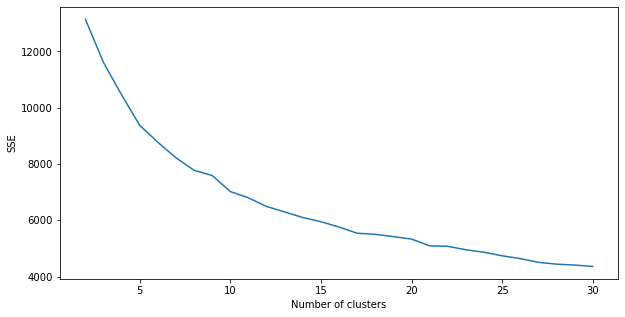

In [4]:
clusters = list(range(2,31,1))

sse = {}
for cluster in clusters:
    kmeans = KMeans(n_clusters=cluster, max_iter=1000, random_state=44, n_jobs=-2).fit(adultX)
    sse[cluster] = kmeans.inertia_
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of clusters")
plt.ylabel("SSE")
plt.show()

### Calculate Silhuette and homogenity scores

For n_clusters=2, The Silhouette Coefficient is 0.39950187115888575
For n_clusters=2, The homogeneity_score is 0.001267670189497016
For n_clusters=3, The Silhouette Coefficient is 0.2610466114273564
For n_clusters=3, The homogeneity_score is 0.00621586092145081
For n_clusters=4, The Silhouette Coefficient is 0.2534312068639792
For n_clusters=4, The homogeneity_score is 0.02527565159125147
For n_clusters=5, The Silhouette Coefficient is 0.23383103647349873
For n_clusters=5, The homogeneity_score is 0.025310598088482333
For n_clusters=6, The Silhouette Coefficient is 0.24526062030462417
For n_clusters=6, The homogeneity_score is 0.025752238383749175
For n_clusters=7, The Silhouette Coefficient is 0.23783720865926783
For n_clusters=7, The homogeneity_score is 0.02623329220121959
For n_clusters=8, The Silhouette Coefficient is 0.24477026278476477
For n_clusters=8, The homogeneity_score is 0.02424750317456016
For n_clusters=9, The Silhouette Coefficient is 0.24086280576067534
For n_clusters

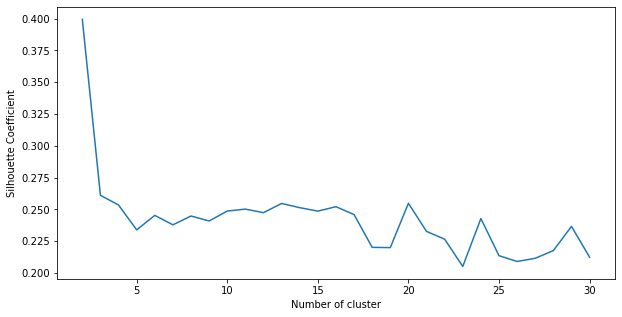

In [5]:
silh = {}
homog = {}
for cluster in range(2, 31, 1):
    kmeans = KMeans(n_clusters=cluster, n_init=50, max_iter=1000, random_state=44, 
                    n_jobs=-2).fit(adultX)
    label = kmeans.labels_
    sil_coeff = silhouette_score(adultX, label, metric='euclidean')
    homog_score = homogeneity_score(adultY, label)
    silh[cluster] = sil_coeff
    homog[cluster] = homog_score
    print("For n_clusters={}, The Silhouette Coefficient is {}".format(cluster, sil_coeff))
    print("For n_clusters={}, The homogeneity_score is {}".format(cluster, homog_score))
plt.figure()
plt.plot(list(silh.keys()), list(silh.values()))
plt.xlabel("Number of cluster")
plt.ylabel("Silhouette Coefficient")
plt.show()

### Plot Silhuette and homogenity scores

Text(0, 0.5, 'Silhouette Coefficient')

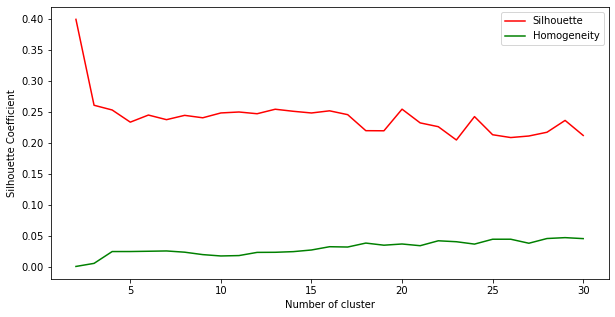

In [6]:
plt.figure()
plt.plot(list(silh.keys()), list(silh.values()), 'r', label="Silhouette")
plt.plot(list(homog.keys()), list(homog.values()), 'g', label="Homogeneity")
plt.legend()
plt.xlabel("Number of cluster")
plt.ylabel("Silhouette Coefficient")

### Comparing Cluster Against Existing Classes

In [7]:
kmeans = KMeans(n_clusters=2, n_init=150, max_iter=1000, random_state=44, n_jobs=-2).fit(adultX)
y_means_pred = kmeans.predict(adultX)
print(classification_report(adultY.values.ravel(), y_means_pred))

              precision    recall  f1-score   support

           0       0.76      0.66      0.71     25070
           1       0.21      0.30      0.25      7491

    accuracy                           0.58     32561
   macro avg       0.48      0.48      0.48     32561
weighted avg       0.63      0.58      0.60     32561



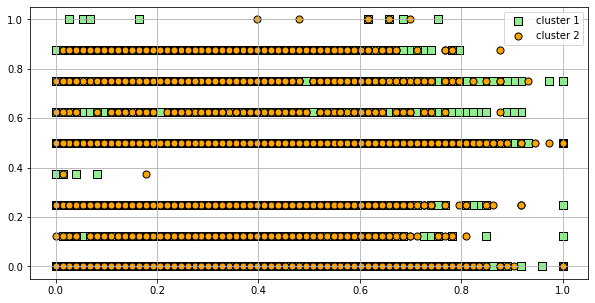

In [8]:
# plot the 3 clusters
plt.scatter(
    adultX[y_means_pred == 0, 0], adultX[y_means_pred == 0, 1],
    s=50, c='lightgreen',
    marker='s', edgecolor='black',
    label='cluster 1'
)

plt.scatter(
adultX[y_means_pred == 1, 0], adultX[y_means_pred == 1, 1],
    s=50, c='orange',
    marker='o', edgecolor='black',
    label='cluster 2'
)

plt.legend(scatterpoints=1)
plt.grid()
plt.show()

### EXPECTATION MAXIMIZATION

For n_clusters=2, The Silhouette Coefficient is 0.39950187115888575
For n_clusters=2, The homogeneity_score is 0.001267670189497016
For n_clusters=2, The log_likelihood score is 10.403312447295857
For n_clusters=3, The Silhouette Coefficient is 0.18040617722657756
For n_clusters=3, The homogeneity_score is 0.007993786762648478
For n_clusters=3, The log_likelihood score is 17.79192816694486
For n_clusters=4, The Silhouette Coefficient is 0.1707756526931962
For n_clusters=4, The homogeneity_score is 0.006013877127429736
For n_clusters=4, The log_likelihood score is 20.251912203426414
For n_clusters=5, The Silhouette Coefficient is 0.09934447623642062
For n_clusters=5, The homogeneity_score is 0.011538380556878274
For n_clusters=5, The log_likelihood score is 21.849519695466746
For n_clusters=6, The Silhouette Coefficient is 0.0620194228797439
For n_clusters=6, The homogeneity_score is 0.01459058785427534
For n_clusters=6, The log_likelihood score is 23.56263638117403
For n_clusters=7, Th

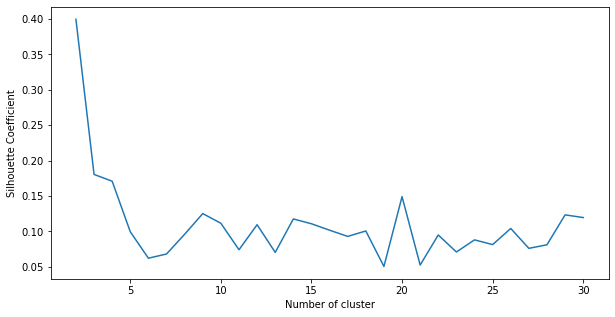

In [9]:
silh_EM = {}
homog_EM = {}
log_likelihood_EM = {}
for cluster in clusters:
    gmm = GaussianMixture(n_components=cluster, max_iter=100, random_state=44, 
                          n_init=5).fit(adultX)
    label = gmm.predict(adultX)
    sil_coeff = silhouette_score(adultX, label, metric='euclidean')
    homog_score = homogeneity_score(adultY, label)
    silh_EM[cluster] = sil_coeff
    homog_EM[cluster] = homog_score
    log_likelihood_EM[cluster] = gmm.score(adultX)
    print("For n_clusters={}, The Silhouette Coefficient is {}".format(cluster, sil_coeff))
    print("For n_clusters={}, The homogeneity_score is {}".format(cluster, homog_score))
    print("For n_clusters={}, The log_likelihood score is {}".format(cluster, log_likelihood_EM[cluster]))

    
plt.figure()
plt.plot(list(silh_EM.keys()), list(silh_EM.values()))
plt.xlabel("Number of cluster")
plt.ylabel("Silhouette Coefficient")
plt.show()

Text(0, 0.5, 'Silhouette Coefficient')

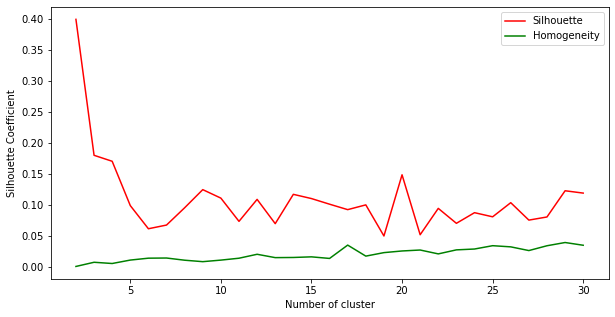

In [10]:
plt.figure()
plt.plot(list(silh_EM.keys()), list(silh_EM.values()), 'r', label="Silhouette")
plt.plot(list(homog_EM.keys()), list(homog_EM.values()), 'g', label="Homogeneity")
plt.legend()
plt.xlabel("Number of cluster")
plt.ylabel("Silhouette Coefficient")

### Comparing Cluster Against Existing Classes

In [11]:
gmm = GaussianMixture(n_components=2, max_iter=100, random_state=44, 
                      n_init=5).fit(adultX)
y_gmm_pred = gmm.predict(adultX)
print(classification_report(adultY.values.ravel(), y_gmm_pred))

              precision    recall  f1-score   support

           0       0.76      0.66      0.71     25070
           1       0.21      0.30      0.25      7491

    accuracy                           0.58     32561
   macro avg       0.48      0.48      0.48     32561
weighted avg       0.63      0.58      0.60     32561



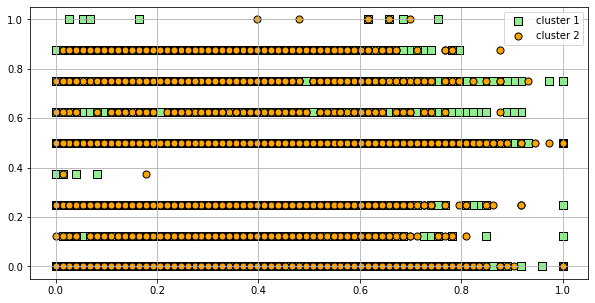

In [12]:
# plot the 2 clusters
plt.scatter(
    adultX[y_gmm_pred == 0, 0], adultX[y_gmm_pred == 0, 1],
    s=50, c='lightgreen',
    marker='s', edgecolor='black',
    label='cluster 1'
)

plt.scatter(
adultX[y_gmm_pred == 1, 0], adultX[y_gmm_pred == 1, 1],
    s=50, c='orange',
    marker='o', edgecolor='black',
    label='cluster 2'
)

plt.legend(scatterpoints=1)
plt.grid()
plt.show()

### PCA

In [13]:
dims_adult = list(range(2,13,1))

for dim in dims_adult:
    pca = PCA(n_components=dim, random_state=44)
    pca.fit_transform(adultX)
    
    # reconstruction
    x_prime = pca.fit_transform(adultX)
    A = np.linalg.pinv(pca.components_.T)
    reconstructed = np.dot(x_prime, A)
    rc_err = mean_squared_error(adultX, reconstructed)    
        
    print(dim, ": ", sum(pca.explained_variance_ratio_), rc_err)


2 :  0.5548576924821486 0.2814143414054219
3 :  0.6635988968578888 0.2754028526080176
4 :  0.7426547684994411 0.2710324440819165
5 :  0.8132450735956089 0.26713003348487535
6 :  0.863988719327752 0.26432479641205214
7 :  0.9090006897002729 0.26183642084920195
8 :  0.9504469288425839 0.25954516792691856
9 :  0.9714897710714512 0.25838186638864213
10 :  0.9843008522004357 0.2576736374230753
11 :  0.992360049615966 0.2572281046072699
12 :  1.0 0.25680574882759505


In [14]:
comp = 7
pca = PCA(n_components=comp, random_state=44)
pca_result = pca.fit_transform(adultX)
for i in range(comp):
    field_name = "pca-"+str(i)
    adultX_df[field_name] = pca_result[:,i]
    adultdata_concat[field_name] = pca_result[:,i]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))
sum(pca.explained_variance_ratio_)
adultX_pca_7 = pca_result


Explained variation per principal component: [0.4142124  0.14064529 0.1087412  0.07905587 0.07059031 0.05074365
 0.04501197]


In [99]:
eigenvalues = pca.explained_variance_
eigenvalues

array([0.27479295, 0.0933056 , 0.07214008, 0.05244651, 0.04683037,
       0.03366388, 0.02986142])

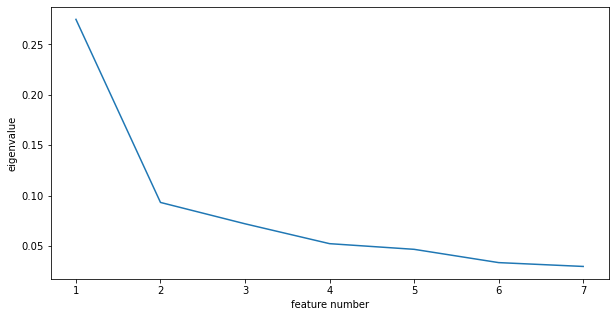

In [103]:
plt.plot(eigenvalues)
plt.xlabel("feature number")
plt.ylabel("eigenvalue")
plt.xticks(np.arange(len(eigenvalues)), np.arange(1, len(eigenvalues)+1))
plt.show()

<AxesSubplot:xlabel='pca-0', ylabel='pca-1'>

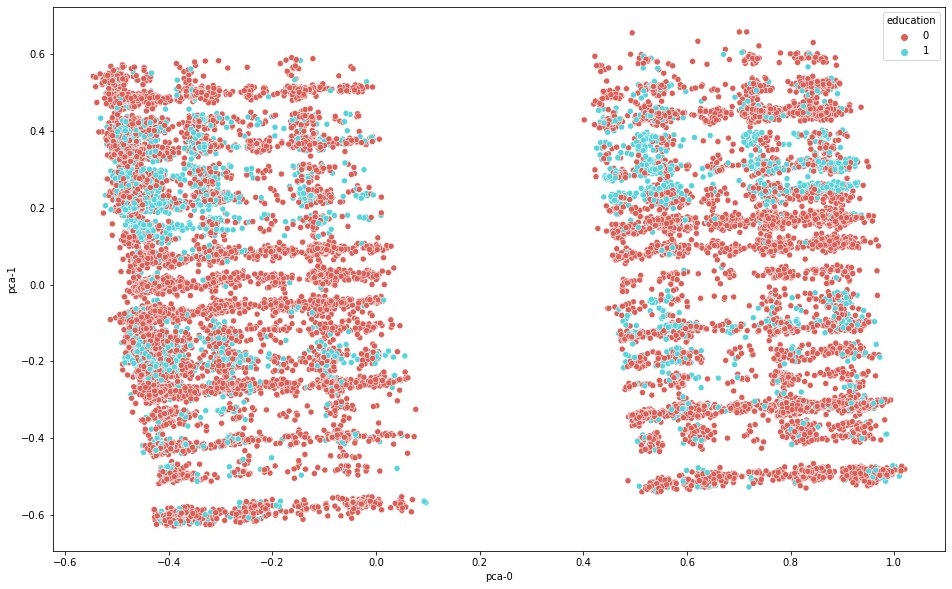

In [15]:
rndperm = np.random.permutation(adultdata_concat.shape[0])
plt.figure(figsize=(16,10))
sns.scatterplot(data=adultdata_concat, x="pca-0", y="pca-1", hue="education",palette=sns.color_palette("hls",2))


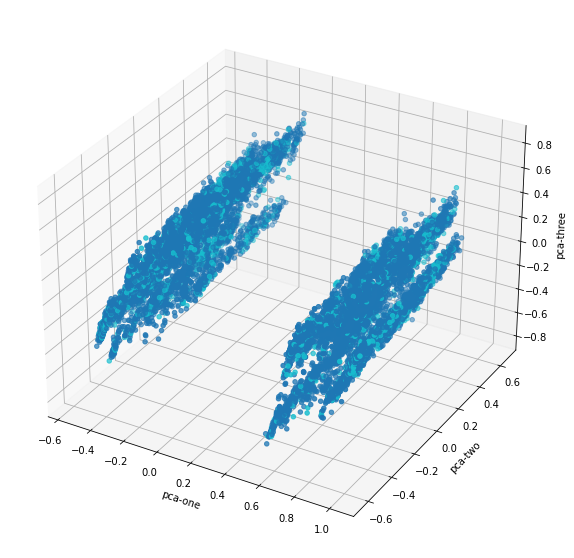

In [16]:
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=adultdata_concat.loc[rndperm,:]["pca-0"], 
    ys=adultdata_concat.loc[rndperm,:]["pca-1"], 
    zs=adultdata_concat.loc[rndperm,:]["pca-2"], 
    c=adultdata_concat.loc[rndperm,:]["education"], 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()


### K-MEANS CLUSTERING AFTER APPLYING PCA

For n_clusters=2, The Silhouette Coefficient is 0.4390379131297225
For n_clusters=2, The homogeneity_score is 0.001267670189497016
For n_clusters=3, The Silhouette Coefficient is 0.3093210957085105
For n_clusters=3, The homogeneity_score is 0.00629345867774387
For n_clusters=4, The Silhouette Coefficient is 0.3107686725757606
For n_clusters=4, The homogeneity_score is 0.024924527841786417
For n_clusters=5, The Silhouette Coefficient is 0.2928655102838205
For n_clusters=5, The homogeneity_score is 0.02531002333448725
For n_clusters=6, The Silhouette Coefficient is 0.3092456350317152
For n_clusters=6, The homogeneity_score is 0.025768513475169244
For n_clusters=7, The Silhouette Coefficient is 0.30298826458382067
For n_clusters=7, The homogeneity_score is 0.026234553354523182
For n_clusters=8, The Silhouette Coefficient is 0.3150655306943903
For n_clusters=8, The homogeneity_score is 0.024213925876877786
For n_clusters=9, The Silhouette Coefficient is 0.32731891752428444
For n_clusters=9

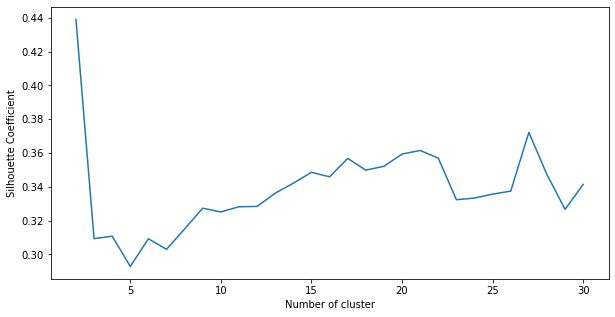

In [17]:
silh = {}
homog = {}
for cluster in range(2, 31, 1):
    kmeans = KMeans(n_clusters=cluster, n_init=50, max_iter=1000, random_state=44, 
                    n_jobs=-2).fit(adultX_pca_7)
    label = kmeans.labels_
    sil_coeff = silhouette_score(adultX_pca_7, label, metric='euclidean')
    homog_score = homogeneity_score(adultY, label)
    silh[cluster] = sil_coeff
    homog[cluster] = homog_score
    print("For n_clusters={}, The Silhouette Coefficient is {}".format(cluster, sil_coeff))
    print("For n_clusters={}, The homogeneity_score is {}".format(cluster, homog_score))
plt.figure()
plt.plot(list(silh.keys()), list(silh.values()))
plt.xlabel("Number of cluster")
plt.ylabel("Silhouette Coefficient")
plt.show()

### EXPECTATION MAXIMIZATION AFTER APPLYING PCA

For n_clusters=2, The Silhouette Coefficient is 0.171616570798244
For n_clusters=2, The homogeneity_score is 0.001646723793806717
For n_clusters=2, The log_likelihood score is 5.749432952413297
For n_clusters=3, The Silhouette Coefficient is 0.2991567821078383
For n_clusters=3, The homogeneity_score is 0.0018370525237095883
For n_clusters=3, The log_likelihood score is 7.421798966989515
For n_clusters=4, The Silhouette Coefficient is 0.25188312181448724
For n_clusters=4, The homogeneity_score is 0.0018391553135328664
For n_clusters=4, The log_likelihood score is 8.568035133295746
For n_clusters=5, The Silhouette Coefficient is 0.25681679109209
For n_clusters=5, The homogeneity_score is 0.002771159459504403
For n_clusters=5, The log_likelihood score is 9.755273256391025
For n_clusters=6, The Silhouette Coefficient is 0.23026252286195692
For n_clusters=6, The homogeneity_score is 0.0043372370065577984
For n_clusters=6, The log_likelihood score is 9.532804770771214
For n_clusters=7, The S

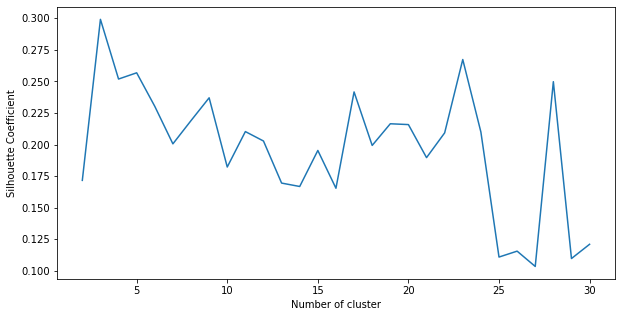

In [18]:
silh_EM = {}
homog_EM = {}
log_likelihood_EM = {}
for cluster in clusters:
    gmm = GaussianMixture(n_components=cluster, max_iter=100, random_state=44, 
                          n_init=5).fit(adultX_pca_7)
    label = gmm.predict(adultX_pca_7)
    sil_coeff = silhouette_score(adultX_pca_7, label, metric='euclidean')
    homog_score = homogeneity_score(adultY, label)
    silh_EM[cluster] = sil_coeff
    homog_EM[cluster] = homog_score
    log_likelihood_EM[cluster] = gmm.score(adultX_pca_7)
    print("For n_clusters={}, The Silhouette Coefficient is {}".format(cluster, sil_coeff))
    print("For n_clusters={}, The homogeneity_score is {}".format(cluster, homog_score))
    print("For n_clusters={}, The log_likelihood score is {}".format(cluster, log_likelihood_EM[cluster]))

    
plt.figure()
plt.plot(list(silh_EM.keys()), list(silh_EM.values()))
plt.xlabel("Number of cluster")
plt.ylabel("Silhouette Coefficient")
plt.show()

### HELPER FUNCTION FOR NEURAL NETWORKS

#### Creating Learning Curve Plot Helper Function

In [19]:
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training instances")
    axes[0].set_ylabel("Score")
    
    train_sizes, train_scores, test_scores, fit_times, _ = \
    learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                   train_sizes=train_sizes,
                   return_times=True)
        
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training instances")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

### NEURAL NETWORK AFTER APPLYING PCA

#### SPLIT PCA Data into train and test

In [20]:
# Splitting data into Train and Test sets
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=10)

adultX_pca_7 = pd.DataFrame(adultX_pca_7, columns = ['Column_A','Column_B','Column_C','Column_D','Column_E','Column_F','Column_G'])
adultY_df = pd.DataFrame(adultY)

# Splitting Adult Dataset
sss.get_n_splits(adultX_pca_7, adultY_df)
for train_index, test_index in sss.split(adultX_pca_7, adultY_df):
    adultx_train, adultx_test = adultX_pca_7.loc[train_index], adultX_pca_7.loc[test_index]
    adulty_train, adulty_test = adultY_df.loc[train_index], adultY_df.loc[test_index]

#### PCA LEARNING CURVES FOR NN USING BEST NEURAL NETWORK FROM ASSIGNMENT 1

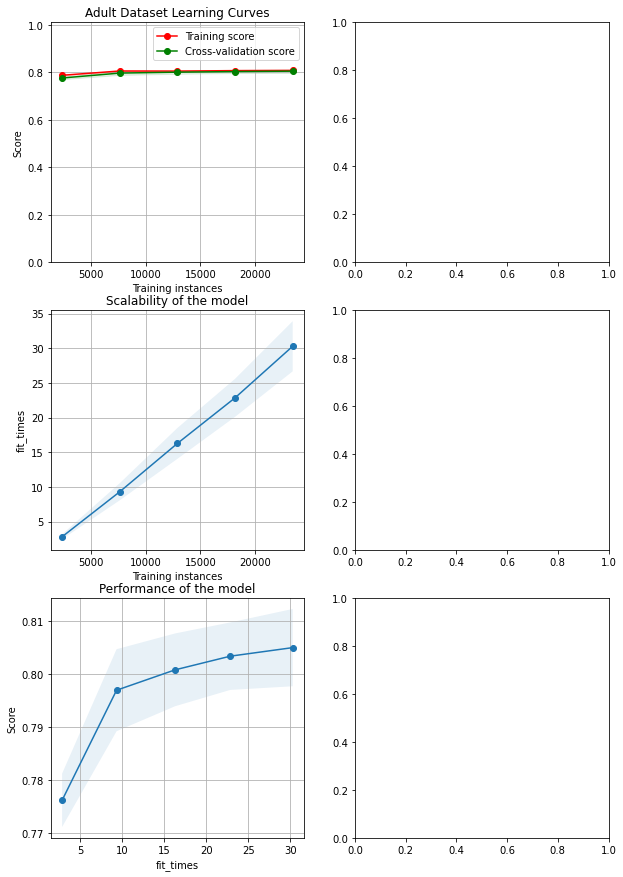

In [21]:
fig, axes = plt.subplots(3, 2, figsize=(10, 15))

X, y = adultx_train, adulty_train

title = "Adult Dataset Learning Curves"
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
best_estimator = MLPClassifier(activation='relu', alpha=0.000125, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=125, learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)
plot_learning_curve(best_estimator, title, X, y, axes=axes[:, 0], ylim=(0.0, 1.01),
                    cv=cv , n_jobs=4)
plt.show()

#### PCA PREDICTIONS FOR NN USING BEST NEURAL NETWORK FROM ASSIGNMENT 1 

In [22]:
# Make Predictions on Adult Dataset
print("\n Adult Dataset Predictions Results")
best_adult_model = MLPClassifier(activation='relu', alpha=0.000125, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=125, learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)
best_adult_model.fit(adultx_train, adulty_train)
adulty_predictions = best_adult_model.predict(adultx_test)
print(classification_report(adulty_test, adulty_predictions,digits=5))
print(confusion_matrix(adulty_test, adulty_predictions))


 Adult Dataset Predictions Results
              precision    recall  f1-score   support

           0    0.82949   0.95354   0.88720      5015
           1    0.68850   0.34379   0.45859      1498

    accuracy                        0.81330      6513
   macro avg    0.75900   0.64867   0.67290      6513
weighted avg    0.79706   0.81330   0.78862      6513

[[4782  233]
 [ 983  515]]


### NEURAL NETWORK AFTER APPLYING PCA AND KMEANS

#### OBTAIN PCA & KMEANS DATA

In [23]:
kmeans = KMeans(n_clusters=22, n_init=50, max_iter=1000, random_state=44, 
                    n_jobs=-2).fit(adultX_pca_7)
label = kmeans.labels_


In [24]:
adultX_pca_kmeans = label.reshape(adultX_pca_7.shape[0],1)
adultX_pca_kmeans = pd.DataFrame(adultX_pca_kmeans)

#### SPLIT PCA & KMEANS Data into train and test

In [25]:
# Splitting data into Train and Test sets
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=10)

# Splitting Adult Dataset
sss.get_n_splits(adultX_pca_kmeans, adultY)
for train_index, test_index in sss.split(adultX_pca_kmeans, adultY):
    adultx_train, adultx_test = adultX_pca_kmeans.loc[train_index], adultX_pca_kmeans.loc[test_index]
    adulty_train, adulty_test = adultY.loc[train_index], adultY.loc[test_index]

#### PCA & KMEANS LEARNING CURVES FOR NN USING BEST NEURAL NETWORK FROM ASSIGNMENT 1

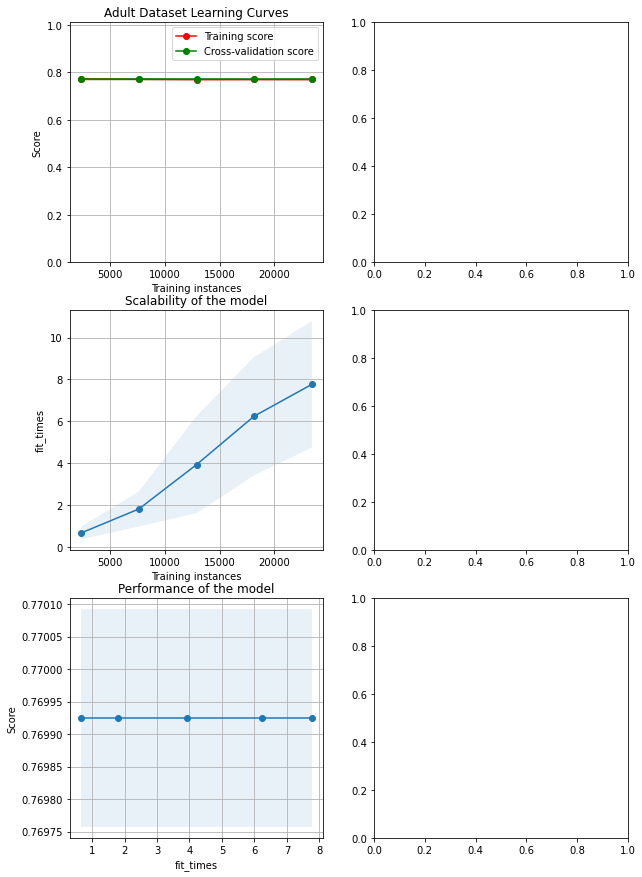

In [26]:
fig, axes = plt.subplots(3, 2, figsize=(10, 15))

X, y = adultx_train, adulty_train

title = "Adult Dataset Learning Curves"
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
best_estimator = MLPClassifier(activation='relu', alpha=0.000125, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=125, learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)
plot_learning_curve(best_estimator, title, X, y, axes=axes[:, 0], ylim=(0.0, 1.01),
                    cv=cv , n_jobs=4)
plt.show()

#### PCA & KMEANS PREDICTIONS FOR NN USING BEST NEURAL NETWORK FROM ASSIGNMENT 1 

In [27]:
# Make Predictions on Adult Dataset
print("\n Adult Dataset Predictions Results")
best_adult_model = MLPClassifier(activation='relu', alpha=0.000125, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=125, learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)
best_adult_model.fit(adultx_train, adulty_train)
adulty_predictions = best_adult_model.predict(adultx_test)
print(classification_report(adulty_test, adulty_predictions,digits=5))
print(confusion_matrix(adulty_test, adulty_predictions))


 Adult Dataset Predictions Results
              precision    recall  f1-score   support

           0    0.77000   1.00000   0.87006      5015
           1    0.00000   0.00000   0.00000      1498

    accuracy                        0.77000      6513
   macro avg    0.38500   0.50000   0.43503      6513
weighted avg    0.59290   0.77000   0.66994      6513

[[5015    0]
 [1498    0]]


### NEURAL NETWORK AFTER APPLYING PCA AND EM

#### OBTAIN PCA & EM DATA

In [28]:
gmm = GaussianMixture(n_components=22, max_iter=100, random_state=44, 
                          n_init=5).fit(adultX_pca_7)
label = gmm.predict(adultX_pca_7)

In [29]:
adultX_pca_em = label.reshape(adultX_pca_7.shape[0],1)
adultX_pca_em = pd.DataFrame(adultX_pca_em)

#### SPLIT PCA & EM Data into train and test

In [30]:
# Splitting data into Train and Test sets
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=10)

# Splitting Adult Dataset
sss.get_n_splits(adultX_pca_em, adultY)
for train_index, test_index in sss.split(adultX_pca_em, adultY):
    adultx_train, adultx_test = adultX_pca_em.loc[train_index], adultX_pca_em.loc[test_index]
    adulty_train, adulty_test = adultY.loc[train_index], adultY.loc[test_index]

#### PCA & EM LEARNING CURVES FOR NN USING BEST NEURAL NETWORK FROM ASSIGNMENT 1

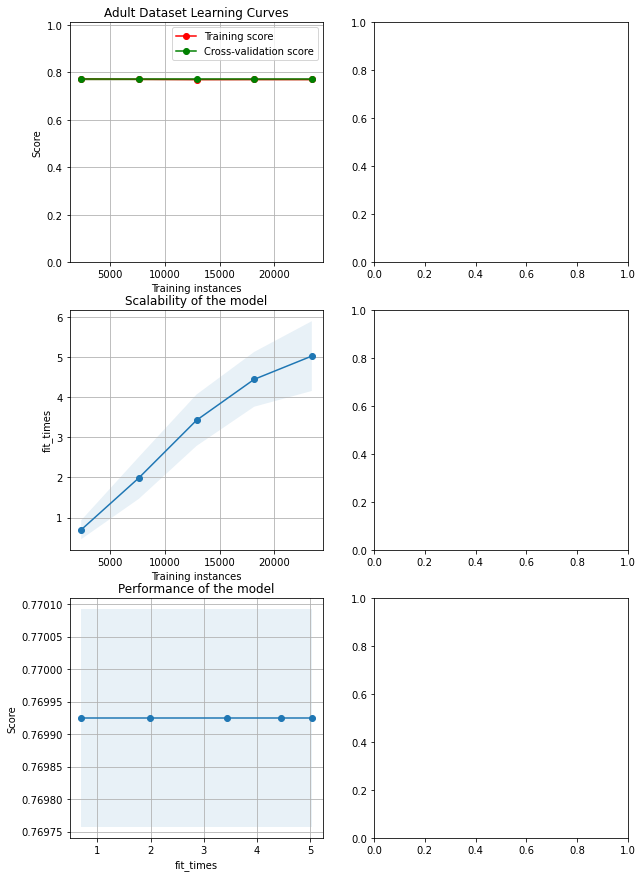

In [31]:
fig, axes = plt.subplots(3, 2, figsize=(10, 15))

X, y = adultx_train, adulty_train

title = "Adult Dataset Learning Curves"
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
best_estimator = MLPClassifier(activation='relu', alpha=0.000125, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=125, learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)
plot_learning_curve(best_estimator, title, X, y, axes=axes[:, 0], ylim=(0.0, 1.01),
                    cv=cv , n_jobs=4)
plt.show()

#### PCA & EM PREDICTIONS FOR NN USING BEST NEURAL NETWORK FROM ASSIGNMENT 1 

In [32]:
# Make Predictions on Adult Dataset
print("\n Adult Dataset Predictions Results")
best_adult_model = MLPClassifier(activation='relu', alpha=0.000125, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=125, learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)
best_adult_model.fit(adultx_train, adulty_train)
adulty_predictions = best_adult_model.predict(adultx_test)
print(classification_report(adulty_test, adulty_predictions,digits=5))
print(confusion_matrix(adulty_test, adulty_predictions))


 Adult Dataset Predictions Results
              precision    recall  f1-score   support

           0    0.77000   1.00000   0.87006      5015
           1    0.00000   0.00000   0.00000      1498

    accuracy                        0.77000      6513
   macro avg    0.38500   0.50000   0.43503      6513
weighted avg    0.59290   0.77000   0.66994      6513

[[5015    0]
 [1498    0]]


### ICA

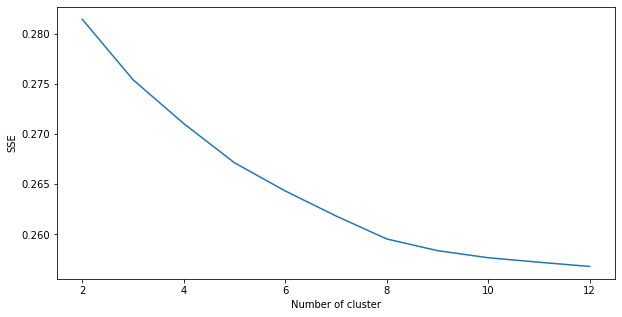

In [33]:
rc_errors = {}
for dim in dims_adult:
    ica = FastICA(n_components=dim, random_state=44)
    x_prime = ica.fit_transform(adultX)
    
    # reconstruction
    A = np.linalg.pinv(ica.components_.T)
    reconstructed = np.dot(x_prime, A)
    rc_err = mean_squared_error(adultX, reconstructed)    
    rc_errors[dim] = rc_err
#     print(dim, ": ", rc_err)
plt.figure()
plt.plot(list(rc_errors.keys()), list(rc_errors.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

In [108]:
comp = 8
ica = FastICA(n_components=comp, random_state=44, max_iter=1000)
ica_result = ica.fit_transform(adultX)
kurt = np.empty(comp)
for i in range(comp):
    field_name = "ica-"+str(i)
    kurt[i] = kurtosis(ica_result[:,i])
    adultX_df[field_name] = ica_result[:,i]
    adultdata_concat[field_name] = ica_result[:,i]
adultX_ica_8 = ica_result

In [35]:
ica_result.shape

(32561, 8)

In [36]:
adultX_df.head()

,age,workclass,fnlwgt,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,pca-0,pca-1,pca-2,pca-3,pca-4,pca-5,pca-6,ica-0,ica-1,ica-2,ica-3,ica-4,ica-5,ica-6,ica-7
0,39.0,7.0,77516.0,4.0,1.0,1.0,4.0,1.0,2174.0,0.0,40.0,39.0,-0.295803,-0.329685,0.210453,-0.101430,-0.135003,0.071899,-0.407108,0.011942,-0.002680,-0.004405,0.010684,-0.001550,-0.003933,0.003363,0.001737
1,50.0,6.0,83311.0,2.0,4.0,0.0,4.0,1.0,0.0,0.0,13.0,39.0,-0.425851,-0.172672,-0.139992,-0.053063,-0.066937,0.019093,-0.193839,0.006759,-0.000651,-0.003240,0.005618,-0.001518,-0.002575,-0.004299,0.001608
2,38.0,4.0,215646.0,0.0,6.0,1.0,4.0,1.0,0.0,0.0,40.0,39.0,-0.373852,-0.075620,-0.243751,0.304359,-0.078499,-0.015120,-0.018519,-0.000167,0.006100,0.006450,0.001431,-0.001477,-0.002508,-0.004613,0.001698
3,53.0,4.0,234721.0,2.0,6.0,0.0,2.0,1.0,0.0,0.0,40.0,39.0,-0.420997,-0.078986,-0.093017,-0.012409,0.391763,-0.246168,-0.042898,0.000384,-0.000849,-0.002621,0.001333,-0.002339,-0.003105,-0.006050,-0.011572
4,28.0,4.0,338409.0,2.0,10.0,5.0,2.0,0.0,0.0,0.0,40.0,5.0,0.913838,0.328021,0.144161,0.417746,0.629672,0.524176,0.051365,0.000988,0.009268,0.003666,-0.005287,0.021887,0.006724,0.005609,-0.008802


<AxesSubplot:xlabel='ica-0', ylabel='ica-1'>

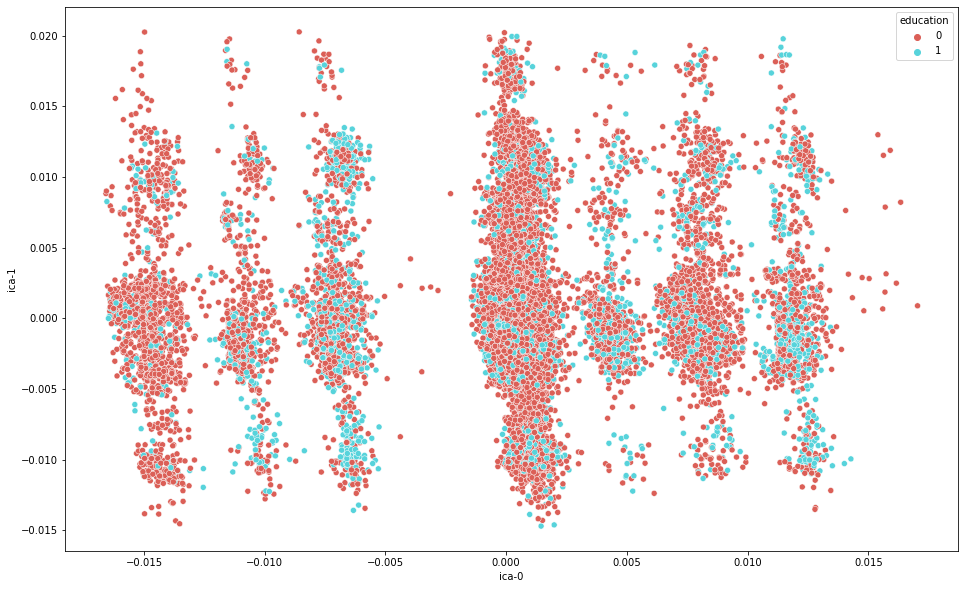

In [37]:
rndperm = np.random.permutation(adultdata_concat.shape[0])
plt.figure(figsize=(16,10))
sns.scatterplot(data=adultdata_concat, x="ica-0", y="ica-1", hue="education",palette=sns.color_palette("hls",2))

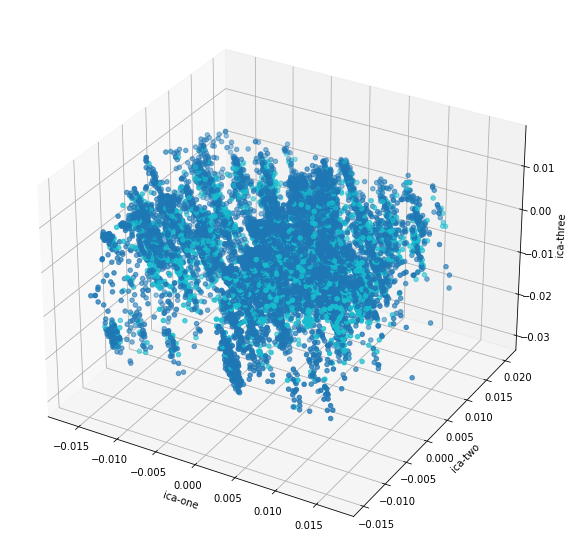

In [38]:
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=adultdata_concat.loc[rndperm,:]["ica-0"], 
    ys=adultdata_concat.loc[rndperm,:]["ica-1"], 
    zs=adultdata_concat.loc[rndperm,:]["ica-2"], 
    c=adultdata_concat.loc[rndperm,:]["education"], 
    cmap='tab10'
)
ax.set_xlabel('ica-one')
ax.set_ylabel('ica-two')
ax.set_zlabel('ica-three')
plt.show()

In [109]:
kurt

array([ 1.68141276,  0.81663393,  2.34712687, -1.25698507, 12.55334635,
       -1.28736473, -0.9539495 ,  4.93097577])

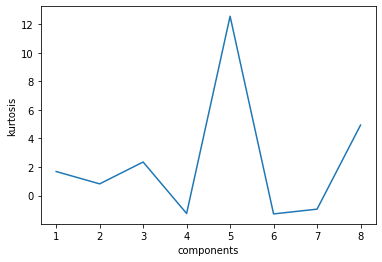

In [110]:
plt.plot(kurt)
plt.xlabel("components")
plt.ylabel("kurtosis")
plt.xticks(np.arange(len(kurt)), np.arange(1, len(kurt)+1))
plt.show()

### K-MEANS CLUSTERING AFTER APPLYING ICA

In [39]:
adultX_ica_8.shape

(32561, 8)

For n_clusters=2, The Silhouette Coefficient is 0.19194586383692688
For n_clusters=2, The homogeneity_score is 0.001267670189497016
For n_clusters=3, The Silhouette Coefficient is 0.21085909573808503
For n_clusters=3, The homogeneity_score is 0.0029919231229053097
For n_clusters=4, The Silhouette Coefficient is 0.22994648209317073
For n_clusters=4, The homogeneity_score is 0.003335402351882845
For n_clusters=5, The Silhouette Coefficient is 0.23904282736665283
For n_clusters=5, The homogeneity_score is 0.003728833575614508
For n_clusters=6, The Silhouette Coefficient is 0.2169836722930454
For n_clusters=6, The homogeneity_score is 0.006529189587154889
For n_clusters=7, The Silhouette Coefficient is 0.20478402449583763
For n_clusters=7, The homogeneity_score is 0.020229037992745717
For n_clusters=8, The Silhouette Coefficient is 0.21755293417346477
For n_clusters=8, The homogeneity_score is 0.015491493067782322
For n_clusters=9, The Silhouette Coefficient is 0.228797312356546
For n_clus

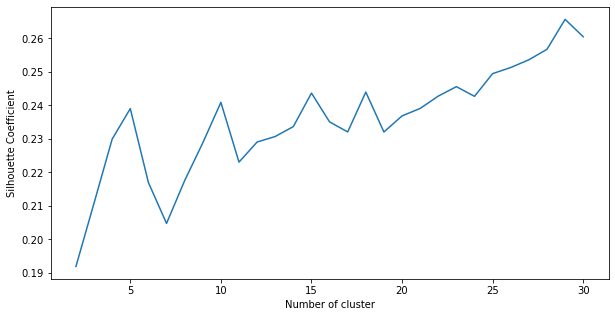

In [40]:
silh = {}
homog = {}
for cluster in list(range(2,31,1)):
    kmeans = KMeans(n_clusters=cluster, n_init=50, max_iter=1000, random_state=44, n_jobs=-2).fit(adultX_ica_8)
    label = kmeans.labels_
    sil_coeff = silhouette_score(adultX_ica_8, label, metric='euclidean')
    homog_score = homogeneity_score(adultY, label)
    silh[cluster] = sil_coeff
    homog[cluster] = homog_score
    print("For n_clusters={}, The Silhouette Coefficient is {}".format(cluster, sil_coeff))
    print("For n_clusters={}, The homogeneity_score is {}".format(cluster, homog_score))
plt.figure()
plt.plot(list(silh.keys()), list(silh.values()))
plt.xlabel("Number of cluster")
plt.ylabel("Silhouette Coefficient")
plt.show()

### EXPECTATION MAXIMIZATION AFTER APPLYING ICA

For n_clusters=2, The Silhouette Coefficient is 0.22826776456399545
For n_clusters=2, The homogeneity_score is 0.0016913909194392067
For n_clusters=2, The log_likelihood score is 33.01522924782566
For n_clusters=3, The Silhouette Coefficient is 0.1859187985756345
For n_clusters=3, The homogeneity_score is 0.001915898140681083
For n_clusters=3, The log_likelihood score is 34.15199632400227
For n_clusters=4, The Silhouette Coefficient is 0.15794897731765944
For n_clusters=4, The homogeneity_score is 0.012861292330369332
For n_clusters=4, The log_likelihood score is 34.69997519796295
For n_clusters=5, The Silhouette Coefficient is 0.16472153689424637
For n_clusters=5, The homogeneity_score is 0.004625761858369301
For n_clusters=5, The log_likelihood score is 35.08925771876104
For n_clusters=6, The Silhouette Coefficient is 0.19576580030887988
For n_clusters=6, The homogeneity_score is 0.007371768970959183
For n_clusters=6, The log_likelihood score is 35.30572441961655
For n_clusters=7, Th

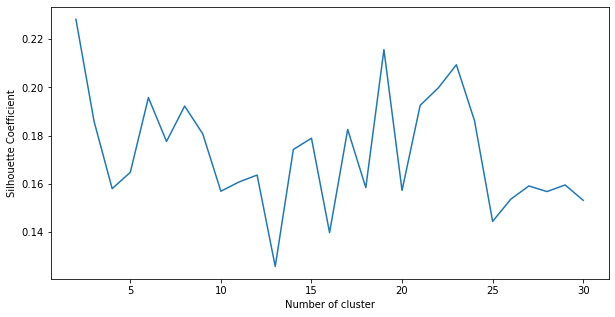

In [41]:
silh_EM = {}
homog_EM = {}
log_likelihood_EM = {}
for cluster in clusters:
    gmm = GaussianMixture(n_components=cluster, max_iter=100, random_state=44, 
                          n_init=5).fit(adultX_ica_8)
    label = gmm.predict(adultX_ica_8)
    sil_coeff = silhouette_score(adultX_ica_8, label, metric='euclidean')
    homog_score = homogeneity_score(adultY, label)
    silh_EM[cluster] = sil_coeff
    homog_EM[cluster] = homog_score
    log_likelihood_EM[cluster] = gmm.score(adultX_ica_8)
    print("For n_clusters={}, The Silhouette Coefficient is {}".format(cluster, sil_coeff))
    print("For n_clusters={}, The homogeneity_score is {}".format(cluster, homog_score))
    print("For n_clusters={}, The log_likelihood score is {}".format(cluster, log_likelihood_EM[cluster]))

    
plt.figure()
plt.plot(list(silh_EM.keys()), list(silh_EM.values()))
plt.xlabel("Number of cluster")
plt.ylabel("Silhouette Coefficient")
plt.show()

### NEURAL NETWORK AFTER APPLYING ICA

#### SPLIT ICA Data into train and test

In [42]:
adultX_ica_8.shape

(32561, 8)

In [43]:
# Splitting data into Train and Test sets
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=10)

adultX_ica_8 = pd.DataFrame(adultX_ica_8, columns = ['Column_A','Column_B','Column_C','Column_D','Column_E','Column_F','Column_G','Column_H'])
adultY_df = pd.DataFrame(adultY)

# Splitting Adult Dataset
sss.get_n_splits(adultX_ica_8, adultY_df)
for train_index, test_index in sss.split(adultX_ica_8, adultY_df):
    adultx_train, adultx_test = adultX_ica_8.loc[train_index], adultX_ica_8.loc[test_index]
    adulty_train, adulty_test = adultY_df.loc[train_index], adultY_df.loc[test_index]

#### ICA LEARNING CURVES FOR NN USING BEST NEURAL NETWORK FROM ASSIGNMENT 1

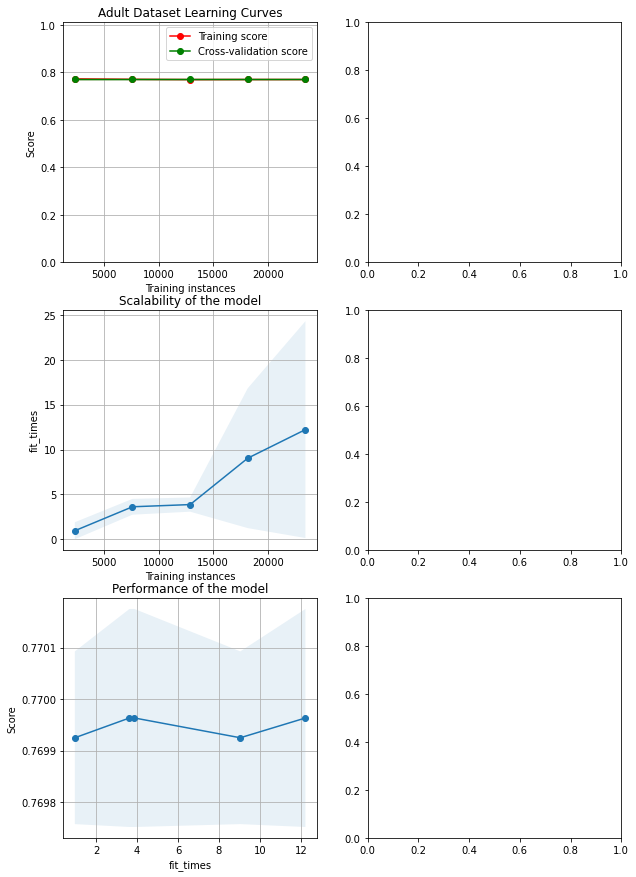

In [44]:
fig, axes = plt.subplots(3, 2, figsize=(10, 15))

X, y = adultx_train, adulty_train

title = "Adult Dataset Learning Curves"
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
best_estimator = MLPClassifier(activation='relu', alpha=0.000125, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=125, learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)
plot_learning_curve(best_estimator, title, X, y, axes=axes[:, 0], ylim=(0.0, 1.01),
                    cv=cv , n_jobs=4)
plt.show()

#### ICA PREDICTIONS FOR NN USING BEST NEURAL NETWORK FROM ASSIGNMENT 1 

In [45]:
# Make Predictions on Adult Dataset
print("\n Adult Dataset Predictions Results")
best_adult_model = MLPClassifier(activation='relu', alpha=0.000125, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=125, learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)
best_adult_model.fit(adultx_train, adulty_train)
adulty_predictions = best_adult_model.predict(adultx_test)
print(classification_report(adulty_test, adulty_predictions,digits=5))
print(confusion_matrix(adulty_test, adulty_predictions))


 Adult Dataset Predictions Results
              precision    recall  f1-score   support

           0    0.77000   1.00000   0.87006      5015
           1    0.00000   0.00000   0.00000      1498

    accuracy                        0.77000      6513
   macro avg    0.38500   0.50000   0.43503      6513
weighted avg    0.59290   0.77000   0.66994      6513

[[5015    0]
 [1498    0]]


### NEURAL NETWORK AFTER APPLYING ICA AND KMEANS

#### OBTAIN ICA & KMEANS DATA

In [46]:
kmeans = KMeans(n_clusters=22, n_init=50, max_iter=1000, random_state=44, 
                    n_jobs=-2).fit(adultX_ica_8)
label = kmeans.labels_


In [47]:
adultX_ica_kmeans = label.reshape(adultX_ica_8.shape[0],1)
adultX_ica_kmeans = pd.DataFrame(adultX_ica_kmeans)

#### SPLIT ICA & KMEANS Data into train and test

In [48]:
# Splitting data into Train and Test sets
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=10)

# Splitting Adult Dataset
sss.get_n_splits(adultX_ica_kmeans, adultY)
for train_index, test_index in sss.split(adultX_ica_kmeans, adultY):
    adultx_train, adultx_test = adultX_ica_kmeans.loc[train_index], adultX_ica_kmeans.loc[test_index]
    adulty_train, adulty_test = adultY.loc[train_index], adultY.loc[test_index]

#### ICA & KMEANS LEARNING CURVES FOR NN USING BEST NEURAL NETWORK FROM ASSIGNMENT 1

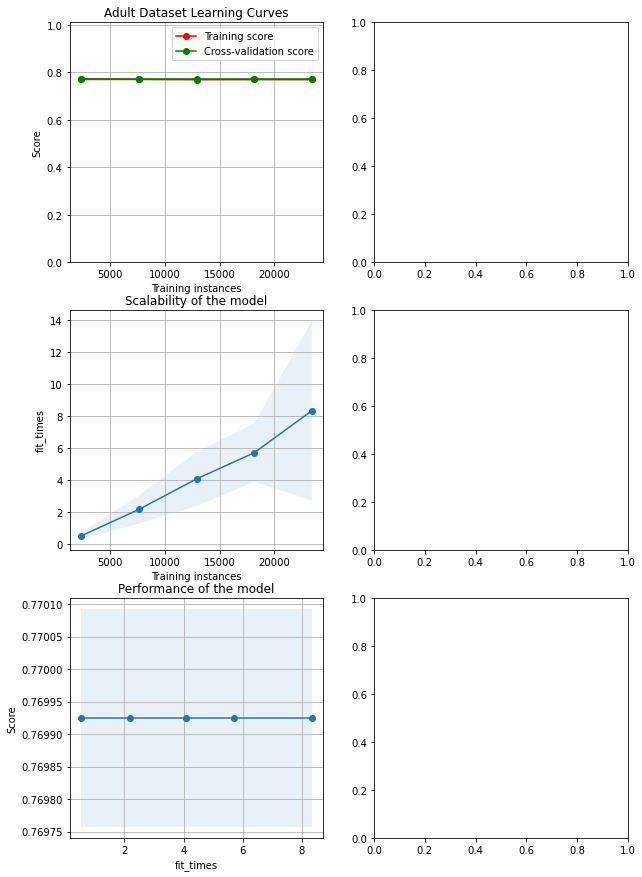

In [49]:
fig, axes = plt.subplots(3, 2, figsize=(10, 15))

X, y = adultx_train, adulty_train

title = "Adult Dataset Learning Curves"
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
best_estimator = MLPClassifier(activation='relu', alpha=0.000125, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=125, learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)
plot_learning_curve(best_estimator, title, X, y, axes=axes[:, 0], ylim=(0.0, 1.01),
                    cv=cv , n_jobs=4)
plt.show()

#### ICA & KMEANS PREDICTIONS FOR NN USING BEST NEURAL NETWORK FROM ASSIGNMENT 1 

In [50]:
# Make Predictions on Adult Dataset
print("\n Adult Dataset Predictions Results")
best_adult_model = MLPClassifier(activation='relu', alpha=0.000125, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=125, learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)
best_adult_model.fit(adultx_train, adulty_train)
adulty_predictions = best_adult_model.predict(adultx_test)
print(classification_report(adulty_test, adulty_predictions,digits=5))
print(confusion_matrix(adulty_test, adulty_predictions))


 Adult Dataset Predictions Results
              precision    recall  f1-score   support

           0    0.77000   1.00000   0.87006      5015
           1    0.00000   0.00000   0.00000      1498

    accuracy                        0.77000      6513
   macro avg    0.38500   0.50000   0.43503      6513
weighted avg    0.59290   0.77000   0.66994      6513

[[5015    0]
 [1498    0]]


### NEURAL NETWORK AFTER APPLYING ICA AND EM

#### OBTAIN iCA & EM DATA

In [51]:
gmm = GaussianMixture(n_components=22, max_iter=100, random_state=44, 
                          n_init=5).fit(adultX_ica_8)
label = gmm.predict(adultX_ica_8)

In [52]:
adultX_ica_em = label.reshape(adultX_ica_8.shape[0],1)
adultX_ica_em = pd.DataFrame(adultX_ica_em)

#### SPLIT ICA & EM Data into train and test

In [53]:
# Splitting data into Train and Test sets
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=10)

# Splitting Adult Dataset
sss.get_n_splits(adultX_ica_em, adultY)
for train_index, test_index in sss.split(adultX_ica_em, adultY):
    adultx_train, adultx_test = adultX_ica_em.loc[train_index], adultX_ica_em.loc[test_index]
    adulty_train, adulty_test = adultY.loc[train_index], adultY.loc[test_index]

#### iCA & EM LEARNING CURVES FOR NN USING BEST NEURAL NETWORK FROM ASSIGNMENT 1

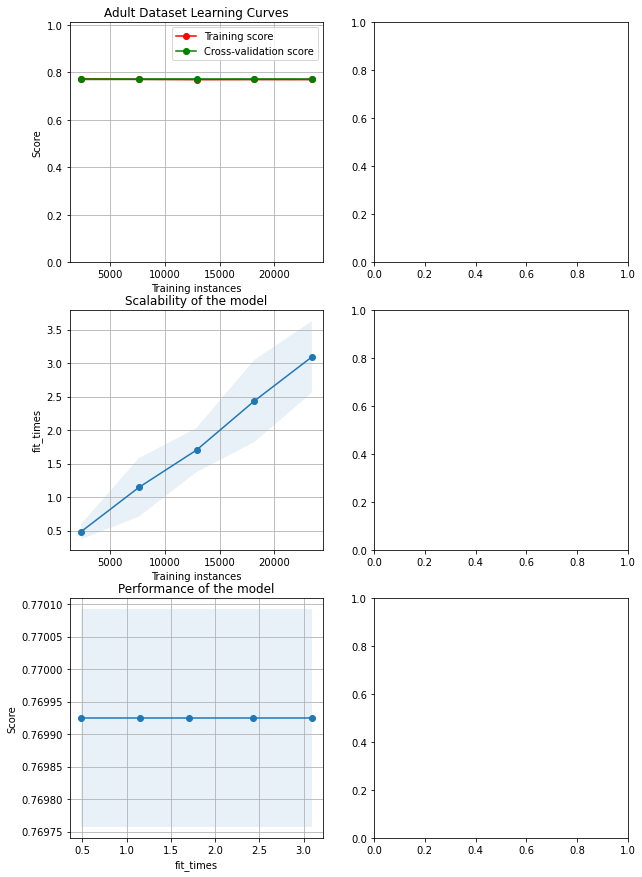

In [54]:
fig, axes = plt.subplots(3, 2, figsize=(10, 15))

X, y = adultx_train, adulty_train

title = "Adult Dataset Learning Curves"
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
best_estimator = MLPClassifier(activation='relu', alpha=0.000125, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=125, learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)
plot_learning_curve(best_estimator, title, X, y, axes=axes[:, 0], ylim=(0.0, 1.01),
                    cv=cv , n_jobs=4)
plt.show()

#### ICA & EM PREDICTIONS FOR NN USING BEST NEURAL NETWORK FROM ASSIGNMENT 1 

In [55]:
# Make Predictions on Adult Dataset
print("\n Adult Dataset Predictions Results")
best_adult_model = MLPClassifier(activation='relu', alpha=0.000125, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=125, learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)
best_adult_model.fit(adultx_train, adulty_train)
adulty_predictions = best_adult_model.predict(adultx_test)
print(classification_report(adulty_test, adulty_predictions,digits=5))
print(confusion_matrix(adulty_test, adulty_predictions))


 Adult Dataset Predictions Results
              precision    recall  f1-score   support

           0    0.77000   1.00000   0.87006      5015
           1    0.00000   0.00000   0.00000      1498

    accuracy                        0.77000      6513
   macro avg    0.38500   0.50000   0.43503      6513
weighted avg    0.59290   0.77000   0.66994      6513

[[5015    0]
 [1498    0]]


### RANDOMIZED PROJECTIONS

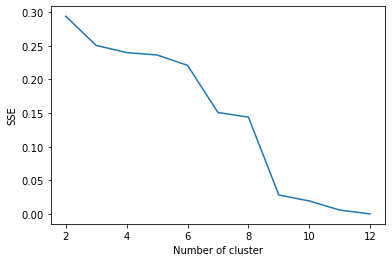

In [111]:
rc_errors = {}
for dim in dims_adult:
    grp = GaussianRandomProjection(n_components=dim, random_state=44)
    x_prime = grp.fit_transform(adultX)
    
    # reconstruction
    A = np.linalg.pinv(grp.components_.T)
    reconstructed = np.dot(x_prime, A)
    rc_err = mean_squared_error(adultX, reconstructed)    
    rc_errors[dim] = rc_err
#     print(dim, ": ", rc_err)
plt.figure()
plt.plot(list(rc_errors.keys()), list(rc_errors.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

In [112]:
comp = 7
grp = GaussianRandomProjection(n_components=comp, random_state=44)
grp_result = grp.fit_transform(adultX)
for i in range(comp):
    field_name = "grp-"+str(i)
    adultX_df[field_name] = grp_result[:,i]
    adultdata_concat[field_name] = grp_result[:,i]
adultX_grp_7 = grp_result

<AxesSubplot:xlabel='grp-0', ylabel='grp-1'>

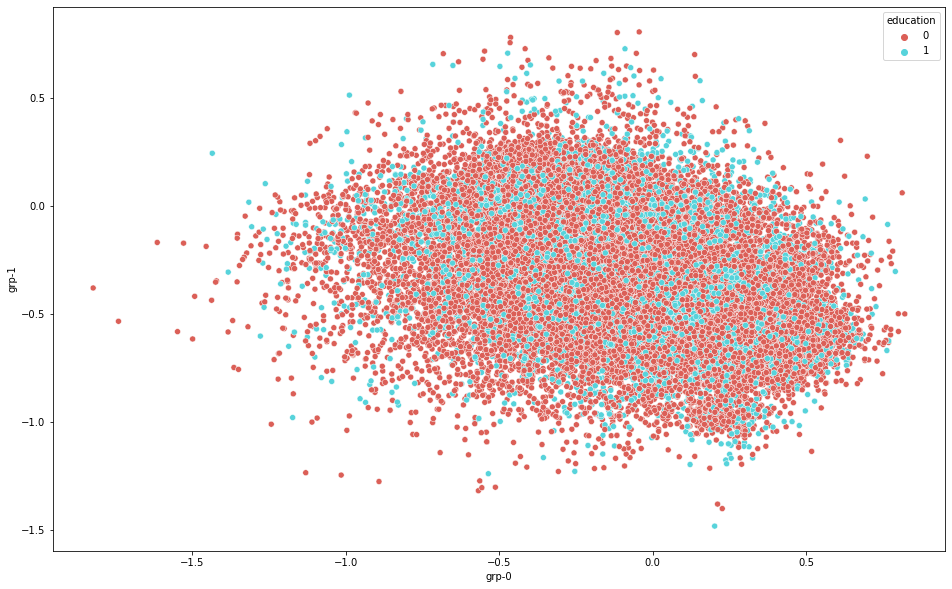

In [113]:
rndperm = np.random.permutation(adultdata_concat.shape[0])
plt.figure(figsize=(16,10))
sns.scatterplot(data=adultdata_concat, x="grp-0", y="grp-1", hue="education",palette=sns.color_palette("hls",2))

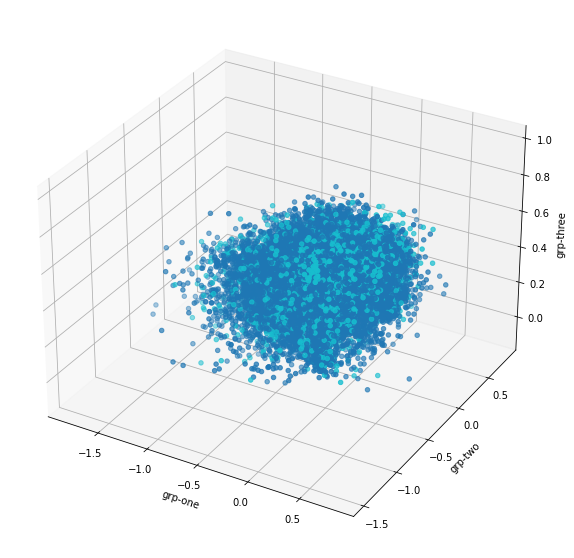

In [114]:
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=adultdata_concat.loc[rndperm,:]["grp-0"], 
    ys=adultdata_concat.loc[rndperm,:]["grp-1"], 
    zs=adultdata_concat.loc[rndperm,:]["grp-2"], 
    c=adultdata_concat.loc[rndperm,:]["education"], 
    cmap='tab10'
)
ax.set_xlabel('grp-one')
ax.set_ylabel('grp-two')
ax.set_zlabel('grp-three')
plt.show()

#### K-MEANS CLUSTERING AFTER APPLYING RANDOMIZED PROJECTIONS

In [115]:
adultX_grp_7.shape

(32561, 7)

For n_clusters=2, The Silhouette Coefficient is 0.3307159780331361
For n_clusters=2, The homogeneity_score is 0.001669127015898065
For n_clusters=3, The Silhouette Coefficient is 0.2990394226394572
For n_clusters=3, The homogeneity_score is 0.003822766974977622
For n_clusters=4, The Silhouette Coefficient is 0.2785542073732964
For n_clusters=4, The homogeneity_score is 0.003929438361793522
For n_clusters=5, The Silhouette Coefficient is 0.21803370937203695
For n_clusters=5, The homogeneity_score is 0.0092742588098799
For n_clusters=6, The Silhouette Coefficient is 0.22677243162872035
For n_clusters=6, The homogeneity_score is 0.01158935627605437
For n_clusters=7, The Silhouette Coefficient is 0.23305575996368322
For n_clusters=7, The homogeneity_score is 0.01232138728125528
For n_clusters=8, The Silhouette Coefficient is 0.23802073038269755
For n_clusters=8, The homogeneity_score is 0.015720842966657496
For n_clusters=9, The Silhouette Coefficient is 0.2328111674305391
For n_clusters=9

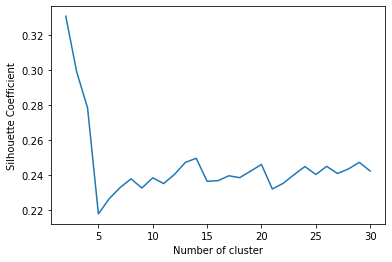

In [116]:
silh = {}
homog = {}
for cluster in list(range(2,31,1)):
    kmeans = KMeans(n_clusters=cluster, n_init=50, max_iter=1000, random_state=44, n_jobs=-2).fit(adultX_grp_7)
    label = kmeans.labels_
    sil_coeff = silhouette_score(adultX_grp_7, label, metric='euclidean')
    homog_score = homogeneity_score(adultY, label)
    silh[cluster] = sil_coeff
    homog[cluster] = homog_score
    print("For n_clusters={}, The Silhouette Coefficient is {}".format(cluster, sil_coeff))
    print("For n_clusters={}, The homogeneity_score is {}".format(cluster, homog_score))
plt.figure()
plt.plot(list(silh.keys()), list(silh.values()))
plt.xlabel("Number of cluster")
plt.ylabel("Silhouette Coefficient")
plt.show()

#### EXPECTATION MAXIMIZATION AFTER APPLYING RANDOMIZED PROJECTIONS

For n_clusters=2, The Silhouette Coefficient is 0.3242369676698429
For n_clusters=2, The homogeneity_score is 0.0012928600258327089
For n_clusters=2, The log_likelihood score is 1.926751958038227
For n_clusters=3, The Silhouette Coefficient is 0.22036464457705524
For n_clusters=3, The homogeneity_score is 0.0023123523279184564
For n_clusters=3, The log_likelihood score is 3.6336199607003743
For n_clusters=4, The Silhouette Coefficient is 0.1793504503917706
For n_clusters=4, The homogeneity_score is 0.002521200313831496
For n_clusters=4, The log_likelihood score is 4.24390799033431
For n_clusters=5, The Silhouette Coefficient is 0.09269071776220889
For n_clusters=5, The homogeneity_score is 0.00846610088404608
For n_clusters=5, The log_likelihood score is 5.30020599558446
For n_clusters=6, The Silhouette Coefficient is 0.0665512639158297
For n_clusters=6, The homogeneity_score is 0.009104880849076399
For n_clusters=6, The log_likelihood score is 6.855948767849639
For n_clusters=7, The S

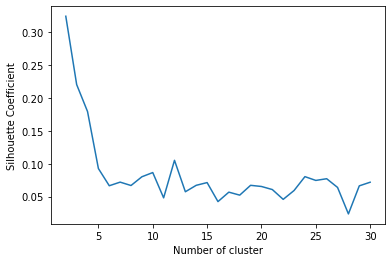

In [117]:
silh_EM = {}
homog_EM = {}
log_likelihood_EM = {}
for cluster in clusters:
    gmm = GaussianMixture(n_components=cluster, max_iter=100, random_state=44, 
                          n_init=5).fit(adultX_grp_7)
    label = gmm.predict(adultX_grp_7)
    sil_coeff = silhouette_score(adultX_grp_7, label, metric='euclidean')
    homog_score = homogeneity_score(adultY, label)
    silh_EM[cluster] = sil_coeff
    homog_EM[cluster] = homog_score
    log_likelihood_EM[cluster] = gmm.score(adultX_grp_7)
    print("For n_clusters={}, The Silhouette Coefficient is {}".format(cluster, sil_coeff))
    print("For n_clusters={}, The homogeneity_score is {}".format(cluster, homog_score))
    print("For n_clusters={}, The log_likelihood score is {}".format(cluster, log_likelihood_EM[cluster]))

    
plt.figure()
plt.plot(list(silh_EM.keys()), list(silh_EM.values()))
plt.xlabel("Number of cluster")
plt.ylabel("Silhouette Coefficient")
plt.show()

#### NEURAL NETWORK AFTER APPLYING RANDOMIZED PROJECTIONS

#### SPLIT RANDOMIZED PROJECTIONS Data into train and test

In [118]:
adultX_grp_7.shape

(32561, 7)

In [120]:
# Splitting data into Train and Test sets
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=10)

adultX_grp_7 = pd.DataFrame(adultX_grp_7, columns = ['Column_A','Column_B','Column_C','Column_D','Column_E','Column_F','Column_G'])
adultY_df = pd.DataFrame(adultY)

# Splitting Adult Dataset
sss.get_n_splits(adultX_grp_7, adultY_df)
for train_index, test_index in sss.split(adultX_grp_7, adultY_df):
    adultx_train, adultx_test = adultX_grp_7.loc[train_index], adultX_grp_7.loc[test_index]
    adulty_train, adulty_test = adultY_df.loc[train_index], adultY_df.loc[test_index]

#### RANDOMIZED PROJECTIONS LEARNING CURVES FOR NN USING BEST NEURAL NETWORK FROM ASSIGNMENT 1

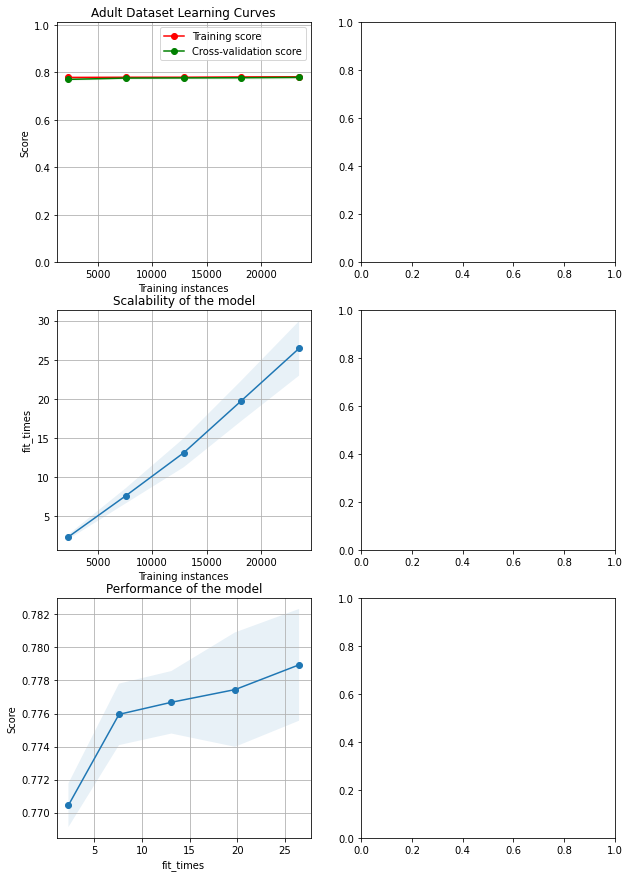

In [121]:
fig, axes = plt.subplots(3, 2, figsize=(10, 15))

X, y = adultx_train, adulty_train

title = "Adult Dataset Learning Curves"
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
best_estimator = MLPClassifier(activation='relu', alpha=0.000125, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=125, learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)
plot_learning_curve(best_estimator, title, X, y, axes=axes[:, 0], ylim=(0.0, 1.01),
                    cv=cv , n_jobs=4)
plt.show()

#### RANDOMIZED PROJECTIONS PREDICTIONS FOR NN USING BEST NEURAL NETWORK FROM ASSIGNMENT 1 

In [122]:
# Make Predictions on Adult Dataset
print("\n Adult Dataset Predictions Results")
best_adult_model = MLPClassifier(activation='relu', alpha=0.000125, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=125, learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)
best_adult_model.fit(adultx_train, adulty_train)
adulty_predictions = best_adult_model.predict(adultx_test)
print(classification_report(adulty_test, adulty_predictions,digits=5))
print(confusion_matrix(adulty_test, adulty_predictions))


 Adult Dataset Predictions Results
              precision    recall  f1-score   support

           0    0.79588   0.97029   0.87447      5015
           1    0.62657   0.16689   0.26357      1498

    accuracy                        0.78551      6513
   macro avg    0.71122   0.56859   0.56902      6513
weighted avg    0.75694   0.78551   0.73396      6513

[[4866  149]
 [1248  250]]


### NEURAL NETWORK AFTER APPLYING RANDOMIZED PROJECTIONS AND KMEANS

#### OBTAIN RANDOMIZED PROJECTIONS & KMEANS DATA

In [123]:
kmeans = KMeans(n_clusters=22, n_init=50, max_iter=1000, random_state=44, 
                    n_jobs=-2).fit(adultX_grp_7)
label = kmeans.labels_

In [124]:
adultX_grp_kmeans = label.reshape(adultX_grp_7.shape[0],1)
adultX_grp_kmeans = pd.DataFrame(adultX_grp_kmeans)

#### SPLIT RANDOMIZED PROJECTIONS & KMEANS Data into train and test

In [125]:
# Splitting data into Train and Test sets
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=10)

# Splitting Adult Dataset
sss.get_n_splits(adultX_grp_kmeans, adultY)
for train_index, test_index in sss.split(adultX_grp_kmeans, adultY):
    adultx_train, adultx_test = adultX_grp_kmeans.loc[train_index], adultX_grp_kmeans.loc[test_index]
    adulty_train, adulty_test = adultY.loc[train_index], adultY.loc[test_index]

#### RANDOMIZED PROJECTIONS & KMEANS LEARNING CURVES FOR NN USING BEST NEURAL NETWORK FROM ASSIGNMENT 1

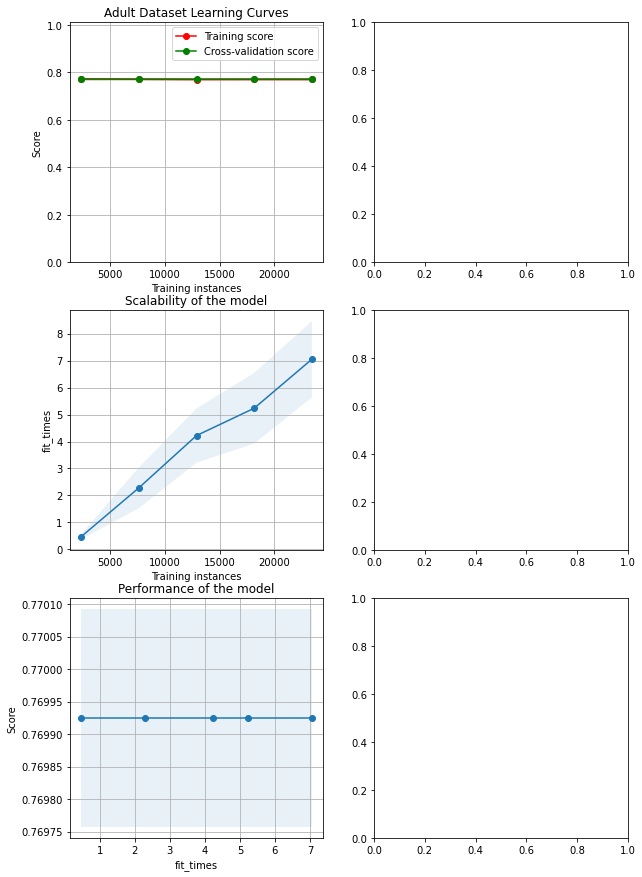

In [126]:
fig, axes = plt.subplots(3, 2, figsize=(10, 15))

X, y = adultx_train, adulty_train

title = "Adult Dataset Learning Curves"
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
best_estimator = MLPClassifier(activation='relu', alpha=0.000125, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=125, learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)
plot_learning_curve(best_estimator, title, X, y, axes=axes[:, 0], ylim=(0.0, 1.01),
                    cv=cv , n_jobs=4)
plt.show()

#### RANDOMIZED PROJECTIONS & KMEANS PREDICTIONS FOR NN USING BEST NEURAL NETWORK FROM ASSIGNMENT 1 

In [127]:
# Make Predictions on Adult Dataset
print("\n Adult Dataset Predictions Results")
best_adult_model = MLPClassifier(activation='relu', alpha=0.000125, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=125, learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)
best_adult_model.fit(adultx_train, adulty_train)
adulty_predictions = best_adult_model.predict(adultx_test)
print(classification_report(adulty_test, adulty_predictions,digits=5))
print(confusion_matrix(adulty_test, adulty_predictions))


 Adult Dataset Predictions Results
              precision    recall  f1-score   support

           0    0.77000   1.00000   0.87006      5015
           1    0.00000   0.00000   0.00000      1498

    accuracy                        0.77000      6513
   macro avg    0.38500   0.50000   0.43503      6513
weighted avg    0.59290   0.77000   0.66994      6513

[[5015    0]
 [1498    0]]


### NEURAL NETWORK AFTER APPLYING RANDOMIZED PROJECTIONS AND EM

#### OBTAIN RANDOMIZED PROJECTIONS & EM DATA

In [128]:
gmm = GaussianMixture(n_components=22, max_iter=100, random_state=44, 
                          n_init=5).fit(adultX_grp_7)
label = gmm.predict(adultX_grp_7)

In [129]:
adultX_grp_em = label.reshape(adultX_grp_7.shape[0],1)
adultX_grp_em = pd.DataFrame(adultX_grp_em)

#### SPLIT RANDOMIZED PROJECTIONS & EM Data into train and test

In [130]:
# Splitting data into Train and Test sets
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=10)

# Splitting Adult Dataset
sss.get_n_splits(adultX_grp_em, adultY)
for train_index, test_index in sss.split(adultX_grp_em, adultY):
    adultx_train, adultx_test = adultX_grp_em.loc[train_index], adultX_grp_em.loc[test_index]
    adulty_train, adulty_test = adultY.loc[train_index], adultY.loc[test_index]

#### RANDOMIZED PROJECTIONS & EM LEARNING CURVES FOR NN USING BEST NEURAL NETWORK FROM ASSIGNMENT 1

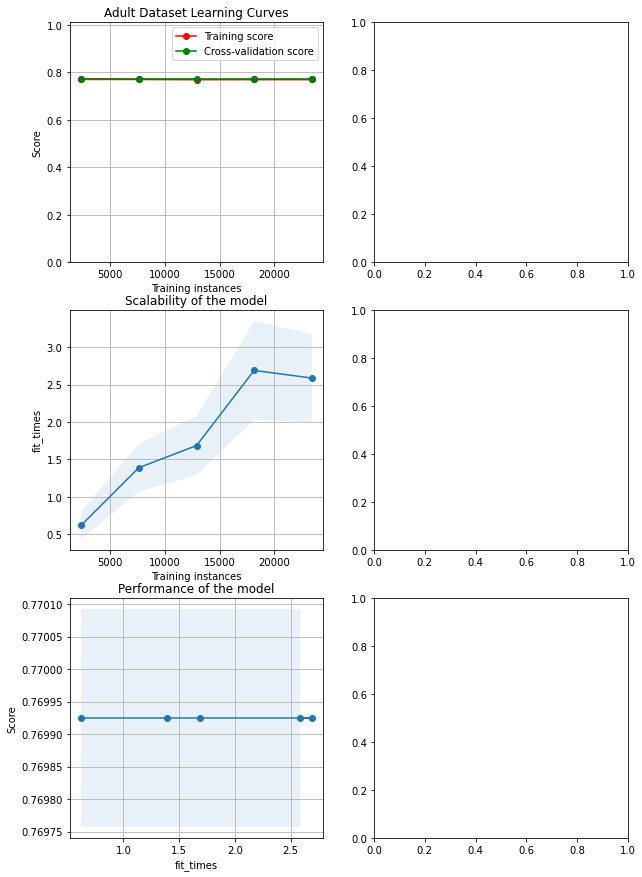

In [131]:
fig, axes = plt.subplots(3, 2, figsize=(10, 15))

X, y = adultx_train, adulty_train

title = "Adult Dataset Learning Curves"
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
best_estimator = MLPClassifier(activation='relu', alpha=0.000125, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=125, learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)
plot_learning_curve(best_estimator, title, X, y, axes=axes[:, 0], ylim=(0.0, 1.01),
                    cv=cv , n_jobs=4)
plt.show()

#### RANDOMIZED PROJECTIONS & EM PREDICTIONS FOR NN USING BEST NEURAL NETWORK FROM ASSIGNMENT 1 

In [132]:
# Make Predictions on Adult Dataset
print("\n Adult Dataset Predictions Results")
best_adult_model = MLPClassifier(activation='relu', alpha=0.000125, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=125, learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)
best_adult_model.fit(adultx_train, adulty_train)
adulty_predictions = best_adult_model.predict(adultx_test)
print(classification_report(adulty_test, adulty_predictions,digits=5))
print(confusion_matrix(adulty_test, adulty_predictions))


 Adult Dataset Predictions Results
              precision    recall  f1-score   support

           0    0.77000   1.00000   0.87006      5015
           1    0.00000   0.00000   0.00000      1498

    accuracy                        0.77000      6513
   macro avg    0.38500   0.50000   0.43503      6513
weighted avg    0.59290   0.77000   0.66994      6513

[[5015    0]
 [1498    0]]


### LASSO FEATURE SELECTION

In [77]:
model = FactorAnalysis(n_components=3, random_state=44)
x_prime = model.fit_transform(adultX)

In [78]:
sfm = SelectFromModel(LassoCV(max_iter=1000), threshold=0.1)
sfm.fit(adultX, adultY)
n_features = sfm.transform(adultX).shape

In [79]:
n_features

(32561, 6)

In [133]:
x_prime = sfm.transform(adultX)

In [134]:
sfm = SelectFromModel(LassoCV(max_iter=1000), max_features=6)
sfm.fit(adultX, adultY)
adultX_6_lasso = sfm.transform(adultX)

In [135]:
adultX_6_lasso.shape

(32561, 6)

#### K-MEANS CLUSTERING AFTER LASSO FEATURE SELECTION

For n_clusters=2, The Silhouette Coefficient is 0.3305440117662511
For n_clusters=2, The homogeneity_score is 0.018468479034741622
For n_clusters=3, The Silhouette Coefficient is 0.30776950428828265
For n_clusters=3, The homogeneity_score is 0.023062015178600424
For n_clusters=4, The Silhouette Coefficient is 0.33277075242376797
For n_clusters=4, The homogeneity_score is 0.03173062577782517
For n_clusters=5, The Silhouette Coefficient is 0.33785604117903095
For n_clusters=5, The homogeneity_score is 0.033242006562025465
For n_clusters=6, The Silhouette Coefficient is 0.28290672016874796
For n_clusters=6, The homogeneity_score is 0.03870086950660905
For n_clusters=7, The Silhouette Coefficient is 0.2706993790176782
For n_clusters=7, The homogeneity_score is 0.04299867808567564
For n_clusters=8, The Silhouette Coefficient is 0.23744203149985732
For n_clusters=8, The homogeneity_score is 0.03507415402002158
For n_clusters=9, The Silhouette Coefficient is 0.22645711290594284
For n_clusters

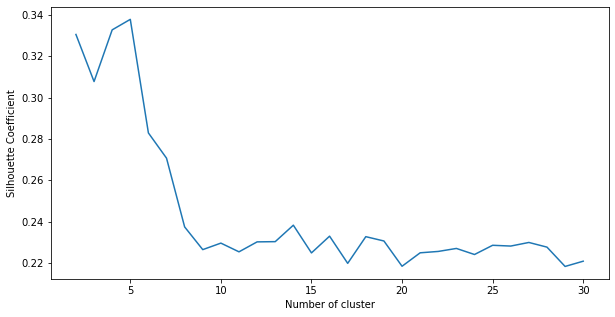

In [83]:
silh = {}
homog = {}
for cluster in list(range(2,31,1)):
    kmeans = KMeans(n_clusters=cluster, n_init=50, max_iter=1000, random_state=44, n_jobs=-2).fit(adultX_8_lasso)
    label = kmeans.labels_
    sil_coeff = silhouette_score(adultX_8_lasso, label, metric='euclidean')
    homog_score = homogeneity_score(adultY, label)
    silh[cluster] = sil_coeff
    homog[cluster] = homog_score
    print("For n_clusters={}, The Silhouette Coefficient is {}".format(cluster, sil_coeff))
    print("For n_clusters={}, The homogeneity_score is {}".format(cluster, homog_score))
plt.figure()
plt.plot(list(silh.keys()), list(silh.values()))
plt.xlabel("Number of cluster")
plt.ylabel("Silhouette Coefficient")
plt.show()

#### EXPECTATION MAXIMIZATION AFTER LASSO FEATURE SELECTION

For n_clusters=2, The Silhouette Coefficient is 0.13485133182447492
For n_clusters=2, The homogeneity_score is 0.00930707272938348
For n_clusters=2, The log_likelihood score is 15.264612050968818
For n_clusters=3, The Silhouette Coefficient is 0.1350205983334258
For n_clusters=3, The homogeneity_score is 0.010077440229613129
For n_clusters=3, The log_likelihood score is 16.346790242976187
For n_clusters=4, The Silhouette Coefficient is 0.06888938890159382
For n_clusters=4, The homogeneity_score is 0.012974481483466048
For n_clusters=4, The log_likelihood score is 16.941820465707046
For n_clusters=5, The Silhouette Coefficient is 0.1774269895146525
For n_clusters=5, The homogeneity_score is 0.024206780825303854
For n_clusters=5, The log_likelihood score is 16.97660465895464
For n_clusters=6, The Silhouette Coefficient is 0.13561636787287443
For n_clusters=6, The homogeneity_score is 0.025724715736378134
For n_clusters=6, The log_likelihood score is 17.426679353734297
For n_clusters=7, T

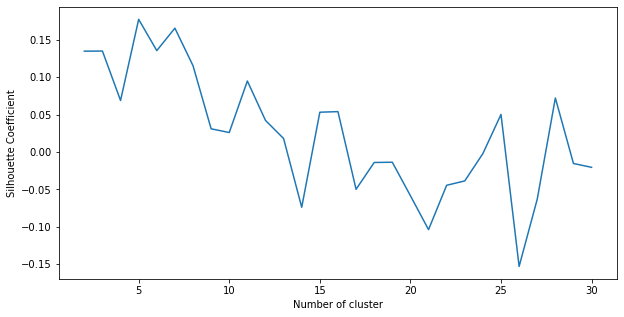

In [84]:
silh_EM = {}
homog_EM = {}
log_likelihood_EM = {}
for cluster in clusters:
    gmm = GaussianMixture(n_components=cluster, max_iter=100, random_state=44, 
                          n_init=5).fit(adultX_8_lasso)
    label = gmm.predict(adultX_8_lasso)
    sil_coeff = silhouette_score(adultX_8_lasso, label, metric='euclidean')
    homog_score = homogeneity_score(adultY, label)
    silh_EM[cluster] = sil_coeff
    homog_EM[cluster] = homog_score
    log_likelihood_EM[cluster] = gmm.score(adultX_8_lasso)
    print("For n_clusters={}, The Silhouette Coefficient is {}".format(cluster, sil_coeff))
    print("For n_clusters={}, The homogeneity_score is {}".format(cluster, homog_score))
    print("For n_clusters={}, The log_likelihood score is {}".format(cluster, log_likelihood_EM[cluster]))

    
plt.figure()
plt.plot(list(silh_EM.keys()), list(silh_EM.values()))
plt.xlabel("Number of cluster")
plt.ylabel("Silhouette Coefficient")
plt.show()

#### NEURAL NETWORK AFTER LASSO FEATURE SELECTION

#### SPLIT LASSO FEATURE SELECTION Data into train and test

In [85]:
adultX_8_lasso.shape

(32561, 8)

In [86]:
# Splitting data into Train and Test sets
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=10)

adultX_8_lasso = pd.DataFrame(adultX_8_lasso, columns = ['Column_A','Column_B','Column_C','Column_D','Column_E','Column_F','Column_G','Column_H'])
adultY_df = pd.DataFrame(adultY)

# Splitting Adult Dataset
sss.get_n_splits(adultX_8_lasso, adultY_df)
for train_index, test_index in sss.split(adultX_8_lasso, adultY_df):
    adultx_train, adultx_test = adultX_8_lasso.loc[train_index], adultX_8_lasso.loc[test_index]
    adulty_train, adulty_test = adultY_df.loc[train_index], adultY_df.loc[test_index]

#### LASSO FEATURE SELECTION LEARNING CURVES FOR NN USING BEST NEURAL NETWORK FROM ASSIGNMENT 1

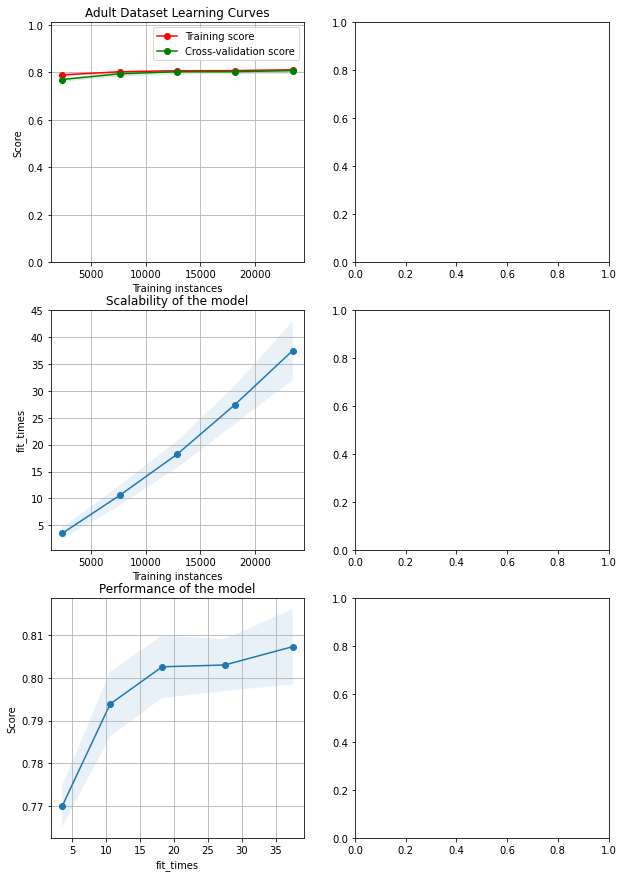

In [87]:
fig, axes = plt.subplots(3, 2, figsize=(10, 15))

X, y = adultx_train, adulty_train

title = "Adult Dataset Learning Curves"
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
best_estimator = MLPClassifier(activation='relu', alpha=0.000125, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=125, learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)
plot_learning_curve(best_estimator, title, X, y, axes=axes[:, 0], ylim=(0.0, 1.01),
                    cv=cv , n_jobs=4)
plt.show()

#### LASSO FEATURE SELECTION PREDICTIONS FOR NN USING BEST NEURAL NETWORK FROM ASSIGNMENT 1 

In [88]:
# Make Predictions on Adult Dataset
print("\n Adult Dataset Predictions Results")
best_adult_model = MLPClassifier(activation='relu', alpha=0.000125, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=125, learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)
best_adult_model.fit(adultx_train, adulty_train)
adulty_predictions = best_adult_model.predict(adultx_test)
print(classification_report(adulty_test, adulty_predictions,digits=5))
print(confusion_matrix(adulty_test, adulty_predictions))


 Adult Dataset Predictions Results
              precision    recall  f1-score   support

           0    0.83006   0.95354   0.88753      5015
           1    0.69016   0.34646   0.46133      1498

    accuracy                        0.81391      6513
   macro avg    0.76011   0.65000   0.67443      6513
weighted avg    0.79789   0.81391   0.78950      6513

[[4782  233]
 [ 979  519]]


### NEURAL NETWORK AFTER LASSO FEATURE SELECTION AND KMEANS

#### OBTAIN LASSO FEATURE SELECTION & KMEANS DATA

In [89]:
kmeans = KMeans(n_clusters=22, n_init=50, max_iter=1000, random_state=44, 
                    n_jobs=-2).fit(adultX_8_lasso)
label = kmeans.labels_

In [90]:
adultX_lasso_kmeans = label.reshape(adultX_8_lasso.shape[0],1)
adultX_lasso_kmeans = pd.DataFrame(adultX_lasso_kmeans)

#### SPLIT LASSO FEATURE SELECTION & KMEANS Data into train and test

In [91]:
# Splitting data into Train and Test sets
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=10)

# Splitting Adult Dataset
sss.get_n_splits(adultX_lasso_kmeans, adultY)
for train_index, test_index in sss.split(adultX_lasso_kmeans, adultY):
    adultx_train, adultx_test = adultX_lasso_kmeans.loc[train_index], adultX_lasso_kmeans.loc[test_index]
    adulty_train, adulty_test = adultY.loc[train_index], adultY.loc[test_index]

#### LASSO FEATURE SELECTION & KMEANS LEARNING CURVES FOR NN USING BEST NEURAL NETWORK FROM ASSIGNMENT 1

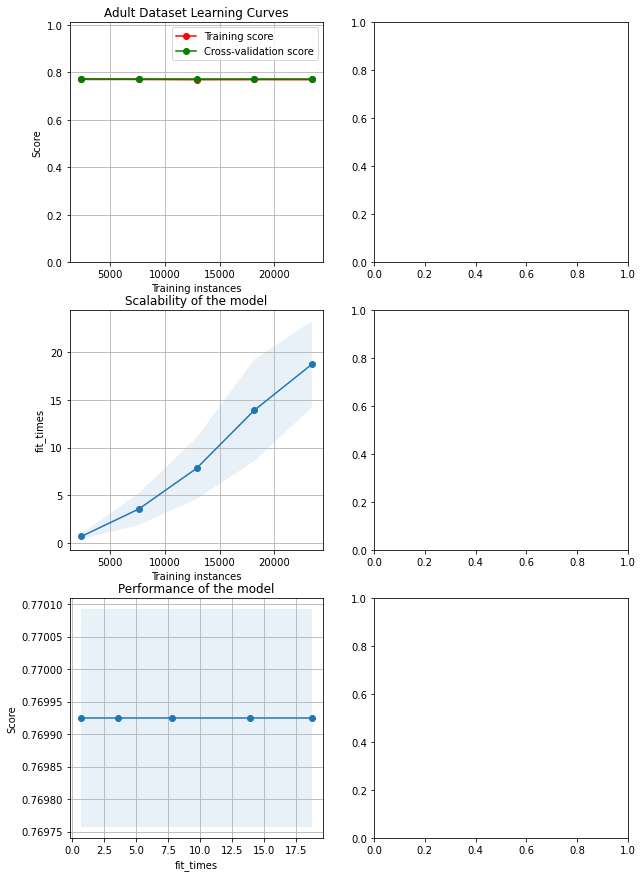

In [92]:
fig, axes = plt.subplots(3, 2, figsize=(10, 15))

X, y = adultx_train, adulty_train

title = "Adult Dataset Learning Curves"
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
best_estimator = MLPClassifier(activation='relu', alpha=0.000125, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=125, learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)
plot_learning_curve(best_estimator, title, X, y, axes=axes[:, 0], ylim=(0.0, 1.01),
                    cv=cv , n_jobs=4)
plt.show()

#### LASSO FEATURE SELECTION & KMEANS PREDICTIONS FOR NN USING BEST NEURAL NETWORK FROM ASSIGNMENT 1 

In [93]:
# Make Predictions on Adult Dataset
print("\n Adult Dataset Predictions Results")
best_adult_model = MLPClassifier(activation='relu', alpha=0.000125, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=125, learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)
best_adult_model.fit(adultx_train, adulty_train)
adulty_predictions = best_adult_model.predict(adultx_test)
print(classification_report(adulty_test, adulty_predictions,digits=5))
print(confusion_matrix(adulty_test, adulty_predictions))


 Adult Dataset Predictions Results
              precision    recall  f1-score   support

           0    0.77000   1.00000   0.87006      5015
           1    0.00000   0.00000   0.00000      1498

    accuracy                        0.77000      6513
   macro avg    0.38500   0.50000   0.43503      6513
weighted avg    0.59290   0.77000   0.66994      6513

[[5015    0]
 [1498    0]]


### NEURAL NETWORK AFTER LASSO FEATURE SELECTION AND EM

#### OBTAIN LASSO FEATURE SELECTION & EM DATA

In [94]:
gmm = GaussianMixture(n_components=22, max_iter=100, random_state=44, 
                          n_init=5).fit(adultX_8_lasso)
label = gmm.predict(adultX_8_lasso)

In [95]:
adultX_lasso_em = label.reshape(adultX_8_lasso.shape[0],1)
adultX_lasso_em = pd.DataFrame(adultX_lasso_em)

#### SPLIT LASSO FEATURE SELECTION  & EM Data into train and test

In [96]:
# Splitting data into Train and Test sets
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=10)

# Splitting Adult Dataset
sss.get_n_splits(adultX_lasso_em, adultY)
for train_index, test_index in sss.split(adultX_lasso_em, adultY):
    adultx_train, adultx_test = adultX_lasso_em.loc[train_index], adultX_lasso_em.loc[test_index]
    adulty_train, adulty_test = adultY.loc[train_index], adultY.loc[test_index]

#### LASSO FEATURE SELECTION & EM LEARNING CURVES FOR NN USING BEST NEURAL NETWORK FROM ASSIGNMENT 1

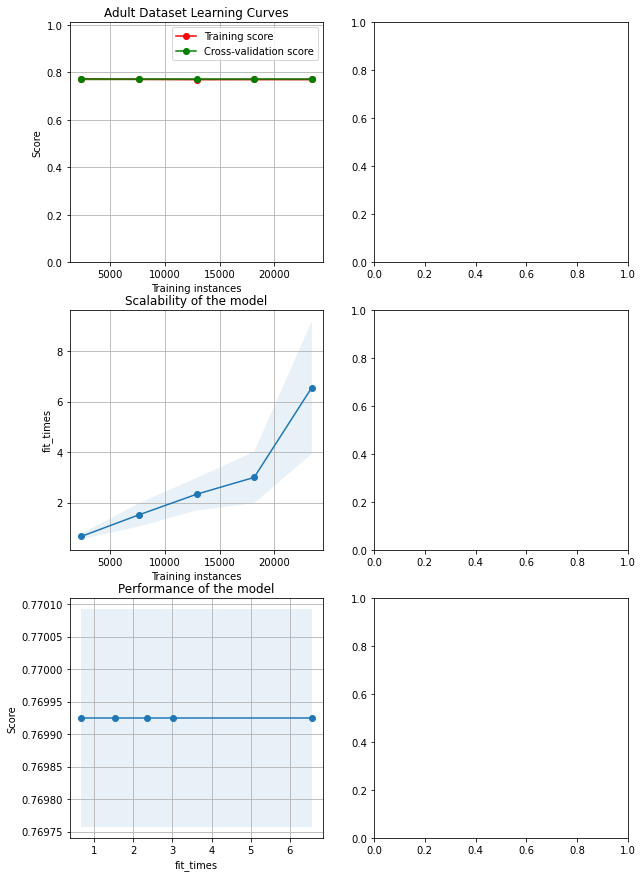

In [97]:
fig, axes = plt.subplots(3, 2, figsize=(10, 15))

X, y = adultx_train, adulty_train

title = "Adult Dataset Learning Curves"
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
best_estimator = MLPClassifier(activation='relu', alpha=0.000125, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=125, learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)
plot_learning_curve(best_estimator, title, X, y, axes=axes[:, 0], ylim=(0.0, 1.01),
                    cv=cv , n_jobs=4)
plt.show()

#### LASSO FEATURE SELECTION & EM PREDICTIONS FOR NN USING BEST NEURAL NETWORK FROM ASSIGNMENT 1 

In [98]:
# Make Predictions on Adult Dataset
print("\n Adult Dataset Predictions Results")
best_adult_model = MLPClassifier(activation='relu', alpha=0.000125, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=125, learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)
best_adult_model.fit(adultx_train, adulty_train)
adulty_predictions = best_adult_model.predict(adultx_test)
print(classification_report(adulty_test, adulty_predictions,digits=5))
print(confusion_matrix(adulty_test, adulty_predictions))


 Adult Dataset Predictions Results
              precision    recall  f1-score   support

           0    0.77000   1.00000   0.87006      5015
           1    0.00000   0.00000   0.00000      1498

    accuracy                        0.77000      6513
   macro avg    0.38500   0.50000   0.43503      6513
weighted avg    0.59290   0.77000   0.66994      6513

[[5015    0]
 [1498    0]]
